# Overview
This blog is a step-by-step account of how we can apply unsupervised machine learning techniques to general and known-customer demographic data sets to build a profile of the core customer base of a mail order sales company.
The problem statement is thus: Given that we can obtain a topography of the underlying demographic clusters of a general population, how can we map a know customer population to this topography and in turn derive its relevant demographic characteristics to create high-precision mail order marketing strategy?
Our success criteria in this respect will be two fold. First, we must be able to build practical interpretations of our demographic clusters to identify the core customer base. That is, translating mathematical data into the financial, familial, and social characteristics of the underlying groups. Secondly, our resulting customer prediction model must have a high precision rate. That is, of the people it identifies as potential customers, a high proportion do actually fit within the demographics of our core customer base.
Four data files are associated with this project:
Udacity_AZDIAS_052018.csv: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
Udacity_CUSTOMERS_052018.csv: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
Udacity_MAILOUT_052018_TRAIN.csv: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
Udacity_MAILOUT_052018_TEST.csv: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including household, building, and neighborhood characteristics.
Alongside the demographics we also used two data dictionaries: 'DIAS Information Levels - Attributes', containing descriptive and hierarchical information for many attributes in the data set, and 'DIAS Attributes - Values', which maps the value domain of many of the attributes to their corresponding meanings, and also provides attribute-level descriptions.

# 2. A high-level exploration of the datasets
Let's load in some libraries that we'll likely require

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

from time import time
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# load in the demographics data for both the general and customer population
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# next, let's load in our data dictionaries
# first, the attribute information
attrib_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

# then load the value dictionary for these attributes
attrib_value_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')

## 2.1 General demographics data

Let's get a general idea of the shape,
quality and meta characteristics of our general demographics dataset.

In [4]:
# shape
azdias.shape

(891221, 366)

In [5]:
# first few records
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
# distinct dtypes and counts of attributes for each
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

Let's get the literal null counts per attribute in the azdias dataframe.
Note that "literal" here denotes actual nulls in the raw dataset. Our total null count will group once we start substituting
missing value codes, which we will encounter in the next section

In [7]:
# literal null counts in the azdias dataframe
azdias_is_null = azdias.isnull()

In [8]:
# null count by attribute (greatest first)
azdias_is_null.sum(axis=0).sort_values(ascending=False)

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_LETZTER_KAUF_BRANCHE       257113
D19_LOTTO                      257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
KBA05_MOTOR                    133324
KBA05_MOD8                     133324
KBA05_MOD4                     133324
KBA05_MOD3                     133324
KBA05_MOD2                     133324
KBA05_SEG1                     133324
KBA05_MOD1                     133324
KBA05_MAXVORB                  133324
KBA05_MAXSEG                   133324
KBA05_MAXHERST                 133324
KBA05_MAXBJ 

Our azdias dataset does contain nulls, with ALTER_KIND4 being the most sparsely-populated attribute, with 890016 nulls out of a total of 891221 values. Also note that there are many attributes with zero nulls. 

# # 2.2 Data dictionaries
Let's take a closer look at our attribute-level data dictionary, which we have called "attrib_info"

In [9]:
attrib_info.head(n=10)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [10]:
attrib_info.tail(n=10)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
303,NaN,NaN,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,NaN
304,NaN,NaN,PLZ8_ANTG4,number of >10 family houses in the PLZ8,NaN
305,NaN,NaN,PLZ8_BAUMAX,most common building-type within the PLZ8,NaN
306,NaN,NaN,PLZ8_HHZ,number of households within the PLZ8,NaN
307,NaN,NaN,PLZ8_GBZ,number of buildings within the PLZ8,NaN
308,NaN,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,NaN,EINWOHNER,inhabitants,NaN
310,NaN,NaN,GKZ,standardized community-code,NaN
311,NaN,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN
312,NaN,NaN,RELAT_AB,share of unemployed in relation to the county ...,NaN


In [11]:
attrib_info['Information level'].value_counts()

Microcell (RR4_ID)    1
PLZ8                  1
Building              1
125m x 125m Grid      1
RR1_ID                1
Community             1
Postcode              1
Person                1
Microcell (RR3_ID)    1
Household             1
Name: Information level, dtype: int64

It appears that each attribute is subdivided according to hierarchy, with some attributes relating to the person (such as gender and financial typology) and others relating to supra-personal entities relating to that person, such as share of unemployed persons in their community.
This information will prove very useful in later sections when we analyse our features for imputation and suitability to
our analysis, but will require some cleaning such as filling forward the information level for each attribute. We will revisit this in the next section.

Finally for this section, let's take a look at the value codes for each attribute, in a dataframe we have called attrib_value_info: 

In [12]:
attrib_value_info.head(20)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


Observe that this dataframe also gives us a description for each attribute itself, as well as their code domains (denoting both actual and missing values) and each codes corresponding meaning.
This dataframe will prove useful in two ways. First, we can use the list missing values listed for each atttribute to get
a true null count per attribute in our dataset. Secondly, it allows us to differentiate between atributes that are linearly-spaced ordinal or categorical in nature, which will prove very useful in the feature selection section.

# 3. Data preprocessing

## 3.1 Missing value codes

### 3.1.1  Identifying missing value codes

In [13]:
# first fill forward Attribute and Description to make the attrib_value_info dataframe easier to work with
attrib_value_info[['Attribute', 'Description']] = attrib_value_info[['Attribute', 'Description']].fillna(method='ffill')

The first step in our data preprocessing is to use attrib_value_info to substitute the missing value codes associated with each attribute in azdias with actual null values. Unfortunately this is not as straighforward as simply searching for the codes associated with the "unknown" meaning for each attribute in attrib_value_info. Take for example the AGER_TYP attribute. From referencing back to the original unsupervised learning project we know that we used -1 and 0 for its missing value codes.
However, notice that only -1 is explicitly defined as "unknown" for AGER_TYP in attrib_value_info, whereas 0 is defined as "no classification possible".
Intuitively, "unknown" and "no classification possible" should mean null regardless of attribute, so we will search for these key words in the "Meaning" column when gathering our missing value codes per attribute.
However ALTERSKATEGORIE_GROB offers a more interesting question. Again referencing back to the clean data dictionary from the term 1 project we note that -1, 0 and 9 are listed as missing value codes, whereas in reality only -1 and 0 represent "unknown" and 9 represents "uniformly distributed". We will also use this term to gather our potential univerise of missing value codes, however we should be careful to note that "uniformly distributed" may not necessarily mean null for non-interval data.

Before searching for these key terms in the Meaning column to gather out potential missing value codes per attribute,
we should first observe where Meaning is null in attrib_value_info to decide whether or not to classify correspond codes as missing value codes

In [14]:
attrib_value_info[attrib_value_info['Meaning'].isnull()]

,Unnamed: 0,Attribute,Description,Value,Meaning
1906,NaN,LP_FAMILIE_GROB,familytyp rough,4,NaN
1907,NaN,LP_FAMILIE_GROB,familytyp rough,5,NaN
1909,NaN,LP_FAMILIE_GROB,familytyp rough,7,NaN
1910,NaN,LP_FAMILIE_GROB,familytyp rough,8,NaN
1912,NaN,LP_FAMILIE_GROB,familytyp rough,10,NaN
1913,NaN,LP_FAMILIE_GROB,familytyp rough,11,NaN
1977,NaN,LP_STATUS_GROB,social status rough,2,NaN
1979,NaN,LP_STATUS_GROB,social status rough,4,NaN
1980,NaN,LP_STATUS_GROB,social status rough,5,NaN
1982,NaN,LP_STATUS_GROB,social status rough,7,NaN


Attributes "LP_FAMILIE_GROB" and "LP_STATUS_GROB" are the only ones that contain null meanings for some of their codes.
Let's have look at their entire code universe to put these null Meanings in context

In [15]:
attrib_value_info[attrib_value_info.Attribute.str.contains("LP_FAMILIE_GROB|LP_STATUS_GROB")]

,Unnamed: 0,Attribute,Description,Value,Meaning
1903,NaN,LP_FAMILIE_GROB,familytyp rough,1,single
1904,NaN,LP_FAMILIE_GROB,familytyp rough,2,couple
1905,NaN,LP_FAMILIE_GROB,familytyp rough,3,single parent
1906,NaN,LP_FAMILIE_GROB,familytyp rough,4,NaN
1907,NaN,LP_FAMILIE_GROB,familytyp rough,5,NaN
1908,NaN,LP_FAMILIE_GROB,familytyp rough,6,family
1909,NaN,LP_FAMILIE_GROB,familytyp rough,7,NaN
1910,NaN,LP_FAMILIE_GROB,familytyp rough,8,NaN
1911,NaN,LP_FAMILIE_GROB,familytyp rough,9,multiperson household
1912,NaN,LP_FAMILIE_GROB,familytyp rough,10,NaN


Interesting, for both attributes there is a definite ascendency in the Meanings in step with the increasing values
(ie: increasing family size and and income respecitvely). Therefore, we can count the values with null meanings as NON-null codes, as they are simply unlabelled steps in a definite hierarchy.

In [16]:
# back to our potential missing value meanings
missing_value_code_meaning_list = ['unknown', 'no classification possible', 'uniformly distributed']
missing_value_code_pattern = '|'.join(missing_value_code_meaning_list)
missing_value_code_mask = attrib_value_info.Meaning.str.contains(missing_value_code_pattern)
missing_value_codes = attrib_value_info[missing_value_code_mask.fillna(value=False)] # ie: we do Not want to count the values with null meanings as potential missing value codes
missing_value_codes['Meaning'].value_counts()

unknown                             232
no classification possible            1
unknown / no main age detectable      1
uniformly distributed                 1
Name: Meaning, dtype: int64

We only have 3 instances of non-unknown meanings according to the above criteria, lets see what kind of attributes these refer to:

In [17]:
missing_value_codes[missing_value_codes['Meaning'] != "unknown"]

,Unnamed: 0,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,0,no classification possible
10,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,9,uniformly distributed
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable


These all seem like valid descriptions of a null for their corresponding attribute. therefore we will include their corresponding values as missing value codes for the given attribute.

In [18]:
# a quick check on the distinct values of our missing value codes:
missing_value_codes['Value'].value_counts()

-1       138
-1, 9     75
-1, 0     16
0          4
-1         1
9          1
Name: Value, dtype: int64

### 3.1.2  Substitution methodology

Now that we have gathered our desired missing value codes per attribute, we are ready to start substituting them in our azdias dataframe. First, let's enrich our missing_value_codes dataframe (itself derived from attrib_value_info) 
with the corresponding dtypes obtained from the general population dataframe. This will help is in our imputation step.

In [19]:
missing_value_codes = missing_value_codes[['Attribute', 'Value']]
# The Value column in missing_value_codes is a mixrute of ints (for single missing value codes for an attribute)
# and strings (for multiple possible value codes)
# Make this a uniform column of string lists
missing_value_codes['Value'] = missing_value_codes['Value'].apply(lambda codes: [str(codes)] if int == type(codes) else codes.split(","))
# create single list of missing value codes per attribute
missing_value_codes_by_attribute = missing_value_codes.groupby('Attribute')['Value'].sum()
# obtain the dtype series of azdias and rename
azdias_dtypes = azdias.dtypes
azdias_dtypes.name = 'azdias_dtypes'
# join corresponding dtypes to our missing value codes, cast to str
missing_value_codes_by_attribute = missing_value_codes_by_attribute.to_frame().join(azdias_dtypes, how='inner')
missing_value_codes_by_attribute['azdias_dtypes'] = missing_value_codes_by_attribute['azdias_dtypes'].astype('str')


In [20]:
# get the distinct dtypes in missing_value_codes_by_attribute
missing_value_codes_by_attribute['azdias_dtypes'].value_counts()

float64    193
int64       30
object       2
Name: azdias_dtypes, dtype: int64

In [21]:
# cast each missing_value_code list according to the associated dtype
Value_typed = []
for missing_value_codes, data_type in missing_value_codes_by_attribute[['Value', 'azdias_dtypes']].values:
    if data_type == 'int64':
        missing_value_codes = list(map(int, missing_value_codes))
    elif data_type == 'float64':
        missing_value_codes = list(map(float, missing_value_codes))
    else:
        missing_value_codes = missing_value_codes
    Value_typed.append(missing_value_codes)
# stored the typed mssing value codes as a new column in missing_value_codes_by_attribute
missing_value_codes_by_attribute['Value_typed'] = Value_typed

In [22]:
# check our derived missing_value_codes_test_by_attribute dataframe
missing_value_codes_by_attribute.head()

,Value,azdias_dtypes,Value_typed
AGER_TYP,"[-1, 0]",int64,"[-1, 0]"
ALTERSKATEGORIE_GROB,"[-1, 0, 9]",int64,"[-1, 0, 9]"
ALTER_HH,[0],float64,[0.0]
ANREDE_KZ,"[-1, 0]",int64,"[-1, 0]"
BALLRAUM,[-1],float64,[-1.0]


Before we replace the missing value codes with nulls, let's print the value counts of AGER_TYP for reference later to ensure that everything ran smoothly

In [23]:
# before we replace, let's print the value counts of AGER_TYP for reference later
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

Post-replacement, we'll expected the -1 and 0 index to disappear.

At this point we should also keep a copy of the original azdias dataframe containing the missing value codes

In [24]:
azdias_copy = azdias.copy()

In [25]:
# perform the replacement
for attribute in missing_value_codes_by_attribute.index:
    print('replacing missing value codes in: ' + attribute)
    azdias[attribute] =  azdias[attribute].replace(missing_value_codes_by_attribute['Value_typed'][attribute], np.nan)

replacing missing value codes in: AGER_TYP
replacing missing value codes in: ALTERSKATEGORIE_GROB
replacing missing value codes in: ALTER_HH
replacing missing value codes in: ANREDE_KZ
replacing missing value codes in: BALLRAUM
replacing missing value codes in: CAMEO_DEUG_2015
replacing missing value codes in: CJT_GESAMTTYP
replacing missing value codes in: EWDICHTE
replacing missing value codes in: FINANZTYP
replacing missing value codes in: FINANZ_ANLEGER
replacing missing value codes in: FINANZ_HAUSBAUER
replacing missing value codes in: FINANZ_MINIMALIST
replacing missing value codes in: FINANZ_SPARER
replacing missing value codes in: FINANZ_UNAUFFAELLIGER
replacing missing value codes in: FINANZ_VORSORGER
replacing missing value codes in: GEBAEUDETYP
replacing missing value codes in: HEALTH_TYP
replacing missing value codes in: HH_EINKOMMEN_SCORE
replacing missing value codes in: INNENSTADT
replacing missing value codes in: KBA05_ALTER1
replacing missing value codes in: KBA05_ALTE

### 3.1.3 Results and discussion

Let's do quick check on AGER_TYP post replacement

In [26]:
azdias['AGER_TYP'].value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

As desired the -1s and 0s have been replace with NANs, and counts for other values have remained intact.
Let's a do a more general before and after comparision for all the attributes in our missing values dataframe.

In [27]:
# original null counts by attribute
original_null_count_by_attribute = azdias_copy.isnull().sum(axis = 0).rename('original_null_count')
# null counts byattribute post-replacement of missing value codes
new_null_count_by_attribute = azdias.isnull().sum(axis = 0).rename('new_null_count')
# join both of the above
null_count_by_attribute_comparision = original_null_count_by_attribute.to_frame().join(new_null_count_by_attribute)
# only view comparision for attributes referenced in missing_value_codes_by_attribute, sort by greatest null count first
null_count_by_attribute_comparision.loc[list(missing_value_codes_by_attribute.index)].sort_values(by = 'new_null_count', ascending=False)

,original_null_count,new_null_count
TITEL_KZ,73499,889061
AGER_TYP,0,685843
KBA05_BAUMAX,133324,476524
ALTER_HH,73499,310267
REGIOTYP,121196,158064
KKK,121196,158064
KBA05_AUTOQUOT,133324,148115
KBA05_MAXBJ,133324,148110
KBA05_MOD2,133324,148110
KBA05_MOD1,133324,148110


The result of our replacement seem valid: the null count per azdias attribute referenced in the  missing value code dataframe has either remained static or increased without ever reaching the total record count for the azdias dataframe (891211)

## 3.2 Feature pruning

### 3.2.1 Methodology

Before we analysis potential attibutes to drop due to high null counts, let's first enriched our
null_count_by_attribute_comparision dataframe with the attribute-level information found in attrib_info

In [28]:
attrib_info_clean = attrib_info[['Attribute', 'Description','Information level']]
attrib_info_clean['Information level'] = attrib_info_clean['Information level'].fillna(method='ffill')
attrib_info_clean = attrib_info_clean.set_index('Attribute')
null_count_by_attribute_comparision = null_count_by_attribute_comparision.join(attrib_info_clean)
null_count_by_attribute_comparision.sort_values(by='new_null_count', ascending=False, inplace=True)
null_count_by_attribute_comparision

,original_null_count,new_null_count,Description,Information level
ALTER_KIND4,890016,890016,NaN,NaN
TITEL_KZ,73499,889061,flag whether this person holds an academic title,Person
ALTER_KIND3,885051,885051,NaN,NaN
ALTER_KIND2,861722,861722,NaN,NaN
ALTER_KIND1,810163,810163,NaN,NaN
AGER_TYP,0,685843,best-ager typology,NaN
EXTSEL992,654153,654153,NaN,NaN
KK_KUNDENTYP,584612,584612,NaN,NaN
KBA05_BAUMAX,133324,476524,most common building-type within the cell,Microcell (RR3_ID)
ALTER_HH,73499,310267,main age within the household,Household


### 3.2.2 Discussion

Observe above that the most empty attributes from ALTER_KIND4 to ALTERSKATEGORIE_FEIN have unique null counts.
Contrast this to the attributes that follow: There are consecutive attributes with the D19 prefix that all share the same
null count. Following those there are two attributes, "KKK" and "REGIOTYP" that also share the same null count and information level (RR1_ID). These "plateaus" of the same null counts suggest that these groups of attributes are in fact only
applicable to certain observations in the general population. In contrast, the large, unique values of the top ranking
11 attributes by null count suggest a true data quality issue with those attributes. Therefore, we will drop these 11 from our analysis.

In [29]:
attributes_to_drop = ['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'ALTER_HH',
 'ALTERSKATEGORIE_FEIN']

In [30]:
azdias.drop(columns=attributes_to_drop, inplace=True)

In [31]:
# verify drop
azdias.shape

(891221, 355)

## 3.3 Record Pruning

### 3.3.1 Methodology for identification of potential records to drop

Let's visualise the distribution of observations by null count in our azdias dataset

In [32]:
azdias_is_null = azdias.isnull()
azdias_null_count_by_record = azdias_is_null.sum(axis=1)

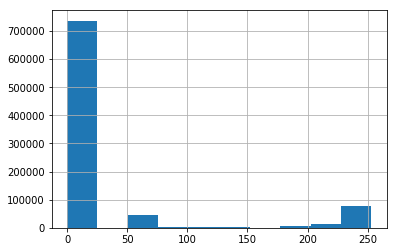

In [33]:
azdias_null_count_by_record.hist();

In [34]:
# count of observations per null count from 0 null count to 25
azdias_null_count_by_record.value_counts(sort=False)[:26]

0     487461
1       5301
2      34824
3      16285
4      10633
5       6088
6       5020
7       2742
8        503
9     126430
10      3683
11     10453
12      4391
13      3189
14      5662
15      7677
16      1393
17       631
18       183
19       113
20      1916
21       115
22       129
23      1433
24        81
25       100
dtype: int64

In [35]:
# total observations with null count less than or equal to 25
azdias_null_count_by_record.value_counts(sort=False)[:26].sum()

736436

In [36]:
# max null count for any record (253)
azdias_null_count_by_record.value_counts(sort=False)[-1:]

253    2
dtype: int64

In [37]:
# total observations with null count greater than or equal to 225
azdias_null_count_by_record.value_counts(sort=False).loc[225:253].sum()

78485

From the above we see that 736436 records have 25 null attributes of less, and 487461 of those have absolutely zero null values. Past 25, the count of records by null count is virtually evenly-distributed, with the except of minor peaks of observations in the 50-75 and 225-250 null count range, the later of which contains approximately 78485 records, or just under an eighth of the whole dataset. Ideally we want to only use fully-populated observations in our future analysis and reduce the amount of impuation we carry out on the original daatset, but for piece of mind we should perform an analysis to detect any qualitiative differences between the fully-enriched observations and the low quality pool of observations we have identified above. Specifically, let's choose a set of attributes that are fully populated across all records and compare their distributions across our fully-populated and more sparsely-populated groups. Similiar distributions for each attribute across the groups will imply no qualitative difference between the groups, and that records containing any number of null attributes can be safely dropped with losing a qualitatively distinct  subgroup from our general population dataset.

### 3.3.2 Qualitative comparision of potential distinct subgroups in the general demographics data

First, let's isolate the zero-null observations in the general population

In [38]:
azdias_high_dq = azdias.dropna()

now let's isolate the 2nd lower quality pool we identified above: records that have at least 225 null values should suffice for this

In [39]:
azdias_low_dq = azdias[azdias_null_count_by_record >= 225]

In [40]:
# verify size of each:
print(azdias_high_dq.shape)
print(azdias_low_dq.shape)

(487461, 355)
(78485, 355)


Now let's identify the attributes we'll analyse the distribution for across the two datasets. Ideally, these candidates should have zero nulls and be of limited domain to obtain clean visualisations. 
Let's join azdias_dtypes to our null_count_by_attribute_comparision dataframe to help identify such attributes.

In [41]:
null_count_by_attribute_comparision = null_count_by_attribute_comparision.join(azdias_dtypes)

Next, let's identify some fully populated attributes in the main azdias dataframe. ideally we want good variation across information levels and/or attribute families (SEMIO_*, FINANZ_* etc.)

In [42]:
# note: int dtypes for a given attribute does not necessarily mean they are ordinal in nature,
# but fot this distribution analysis categoricals are also fine to use
# null_count_by_attribute_comparision where new null count is nt zero and dtype is int
null_count_by_attribute_comparision_ordinal_zeroes = null_count_by_attribute_comparision[(null_count_by_attribute_comparision['new_null_count'] == 0) & (null_count_by_attribute_comparision['azdias_dtypes'] == int)]
null_count_by_attribute_comparision_ordinal_zeroes.reset_index(inplace=True)
# derive a column of attribute prefixes
null_count_by_attribute_comparision_ordinal_zeroes['attribute_prefix'] = null_count_by_attribute_comparision_ordinal_zeroes['index'].apply(lambda s: s.split("_")[0])
# show the first attribute by prefix/family
sample_attribute_by_prefix = null_count_by_attribute_comparision_ordinal_zeroes.groupby('attribute_prefix')['index'].first()
sample_attribute_by_prefix

attribute_prefix
ANREDE                ANREDE_KZ
D19                D19_FREIZEIT
FINANZ           FINANZ_ANLEGER
FINANZTYP             FINANZTYP
GEBURTSJAHR         GEBURTSJAHR
GREEN          GREEN_AVANTGARDE
KOMBIALTER           KOMBIALTER
LNR                         LNR
SEMIO                 SEMIO_FAM
ZABEOTYP               ZABEOTYP
Name: index, dtype: object

In [43]:
azdias_high_dq[list(sample_attribute_by_prefix.values)].head()

,ANREDE_KZ,D19_FREIZEIT,FINANZ_ANLEGER,FINANZTYP,GEBURTSJAHR,GREEN_AVANTGARDE,KOMBIALTER,LNR,SEMIO_FAM,ZABEOTYP
2,2,0,2,1,1979,1,2,910225,1,5
4,1,0,1,5,1963,0,3,910241,4,4
5,2,0,2,2,1943,0,4,910244,4,4
6,2,0,5,4,0,0,2,910248,5,4
7,1,0,1,5,1964,0,3,910261,7,1


Since we want to limit this analysis to attributes of limited domain, let's remove GEBURTSJAHR and LNR

In [44]:
sample_attributes = ['ANREDE_KZ',
 'D19_FREIZEIT',
 'FINANZ_ANLEGER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'KOMBIALTER',
 'SEMIO_FAM',
 'ZABEOTYP']

In [45]:
# write a quick function to plot value count comparisions 
def plot_hist_comparision(df1, df2, c):
    fig, ax =plt.subplots(1,2)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(c + ' - high versus low quality dataset', fontsize=16)
    sns.countplot(x=c, data=df1[[c]], ax=ax[0])
    sns.countplot(x=c, data=df2[[c]], ax=ax[1])
    fig.show()
    return None

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


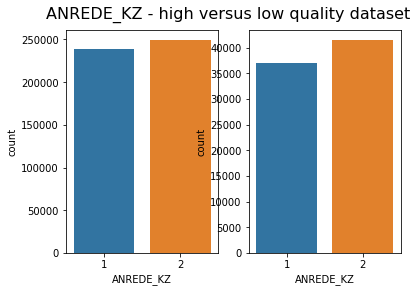

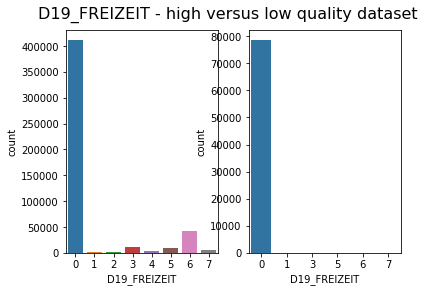

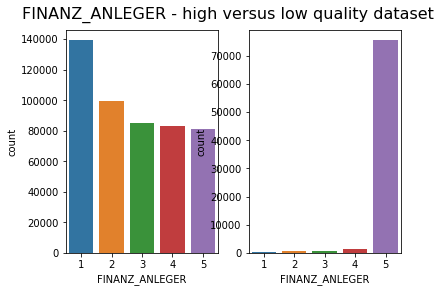

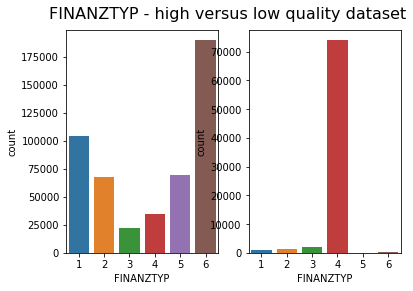

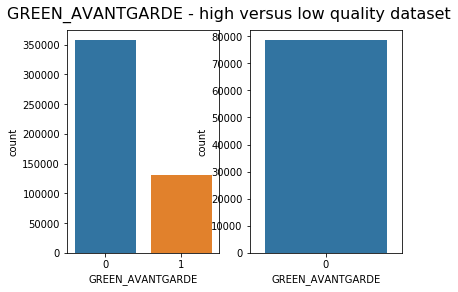

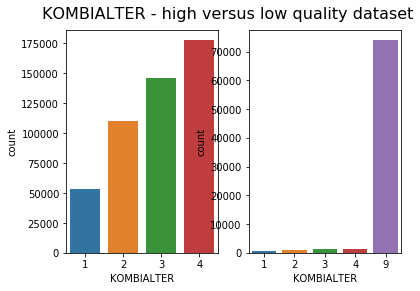

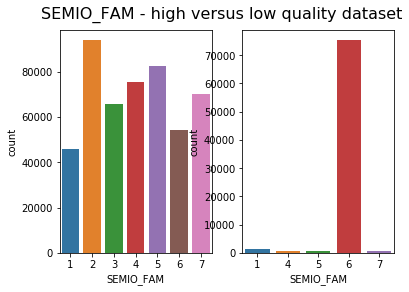

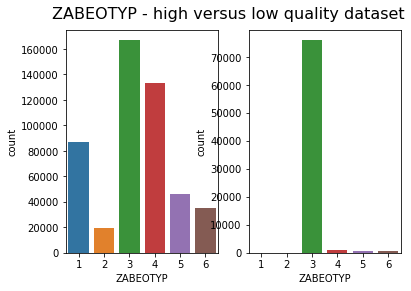

In [46]:
[plot_hist_comparision(azdias_high_dq, azdias_low_dq, attribute) for attribute in sample_attributes];

### Discussion

The above count plots do seem to suggest that our lower quality dataset is indeed qualitatively different to our zero null dataset. With the exception of ANREDE_KZ (gender), D19_FREIZEIT, and GREEN_AVANTGARDE, attributes seem to have particular values overly-represented in the low-quality dataset relative to the zero-null dataset. in particlar:

- The prevailing value for FINANZ_ANLEGER (financial typology: investor), is 5, or "very low"
- The prevailing value for FINANZTYP (type of person, financially), is 4, or 'be prepared'
- The prevailing value for SEMIO_FAM (affinity for familiar-mindedness), is 6, or 'very low'
- The prevailing value for ZABEOTYP (energy consumer type), is 3, or 'fair supplied'

Do these trends give any indication of what this group might actually represent? Well, based on the FINANZ_ANLEGER, FINANZTYP and ZABEOTYP financial characteristics we could tentatively suggest that this group represents low-income savers, perhaps students.

Given the qualitative differences we have seen between the low data-quality observations and zero-null observations
for a set of fully-populated groups, we will not proceed to drop observations with null counts greater than zero. Instead, we will focus on dropping additional features and, if required, the imputation of some of the remaining features.

## 3.4 Further feature selection

### 3.4.1 Criteria for included

Let's take stock of the number of zero-null features currently in our dataset

In [47]:
null_count_by_attribute_comparision.shape

(366, 5)

In [48]:
null_count_by_attribute_comparision[null_count_by_attribute_comparision['new_null_count'] == 0].shape

(86, 5)

We have 86 features that have zero nulls in our dataset. Given that we have resolved to keep all records due to the conclusions we reached in the previous section, feature selection, transformation and derivation will be of particular importantance. We should first focus on identifying non-zero null count attributes that we may want to impute and keep for further analysis.

Given the large number of attributes to work with in this space, let's limit candidates to those adhering to the following criteria:

1. The attribute should have have a relatively low null count.
2. The attribute should be fully documented in the attrib_value_info and/ or attrib_info dataframes so that we know whether it is numerical, ordinal or categorical in nature. In theory we could one-hot encode multi-category attributes, but due to the amount of attributes to work with we will limit out attention to purely numerical and ordinal variables. The one exception here are binary categorisations, in which case we may convert to boolean vectors. We should also point out that all ordinal attributes will be assumed to be linear in spacing, which from exploring the data dictionaries seems like a fair assumption.
Understanding the nature of these attributes will also aid us in the imputation step for these attributes.

### 3.4.2 Possible features for imputation

Based on the criteria stated above, now, let's take a look at the attributes that contain at least one null and carry some Description as possible candidates for imputation. We will also omit attributes of object dtype and those belonging to the KBA family. This family of attributes describe the share of various vehicle types in the microcell of the observation, which I do not think will be particularly useful in our clustering analysis

In [49]:
null_count_by_attribute_comparision.reset_index(inplace=True)

In [50]:
# let's put together some masks to isolate the attributes of interest in null_count_by_attribute_comparision
# null count greater than zero
has_nulls_mask = null_count_by_attribute_comparision['new_null_count'] != 0 
# has some sort of description
has_description_mask = ~null_count_by_attribute_comparision['Description'].isnull()
# is not part of the KBA attribute family
not_kba_mask = ~null_count_by_attribute_comparision['index'].str.contains("^KBA")
# has not been dropped already
not_dropped_mask = null_count_by_attribute_comparision['index'].isin(azdias.columns)
# not of object type
not_object_mask = null_count_by_attribute_comparision['azdias_dtypes'].astype(str) != 'object'

In [51]:
# grab records adhering to the above, sort by lowest null count first
null_count_by_attribute_comparision[has_nulls_mask & has_description_mask & not_kba_mask & not_dropped_mask & not_object_mask].sort_values('new_null_count')

,index,original_null_count,new_null_count,Description,Information level,azdias_dtypes
279,ALTERSKATEGORIE_GROB,0,2881,age through prename analysis,Person,int64
263,LP_LEBENSPHASE_FEIN,4854,4854,lifestage fine,Person,float64
264,LP_LEBENSPHASE_GROB,4854,4854,lifestage rough,Person,float64
265,LP_STATUS_FEIN,4854,4854,social status fine,Person,float64
266,LP_STATUS_GROB,4854,4854,social status rough,Person,float64
278,LP_FAMILIE_GROB,4854,4854,family type rough,Person,float64
269,CJT_GESAMTTYP,4854,4854,Customer-Journey-Typology relating to the pref...,Person,float64
272,GFK_URLAUBERTYP,4854,4854,vacation habits,Person,float64
275,ONLINE_AFFINITAET,4854,4854,online affinity,RR1_ID,float64
277,RETOURTYP_BK_S,4854,4854,return type,Person,float64


Here we enter the judgement call zone in terms of what features to keep and impute.
from a quantitative point of view, the null counts for attributes ALTERSKATEGORIE_GROB through to HH_EINKOMMEN_SCORE
are under 2.5% of the total observation count in azdias. However, we should not include in our analysis fields that not explicitly numerical or ordinal in nature in accordance with our criteria above, which limit us to ALTERSKATEGORIE_GROB (age through prename analysis), HH_EINKOMMEN_SCORE (estimated household income), and ONLINE_AFFINITAET (online affinity).

From experience in project 3, I have seen that the PLZ8 family of attibutes, which concern housing characteristics for
a given observations district, were the most prominant features associated with the principal component that captured
the most variance in that dataset. Therefore we will also keep these as they are ordinal in nature.

Following from this, let's modify our azdias dataset to only include:

1. fully-populated attributes and
2. the null-containing numerical and ordinal attributes for imputation identified above

In [52]:
attributes_zero_nulls = list(null_count_by_attribute_comparision[null_count_by_attribute_comparision['new_null_count'] == 0]['index'])
attributes_to_impute = list(null_count_by_attribute_comparision[null_count_by_attribute_comparision['index'].str.contains("^PLZ8")]['index'])
attributes_to_impute.extend(['ALTERSKATEGORIE_GROB', 'ONLINE_AFFINITAET', 'HH_EINKOMMEN_SCORE'])
attributes_to_keep = attributes_zero_nulls
attributes_to_keep.extend(attributes_to_impute)
attributes_to_keep

['GREEN_AVANTGARDE',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_RAT',
 'SEMIO_PFLICHT',
 'SEMIO_MAT',
 'SEMIO_LUST',
 'SEMIO_KULT',
 'SEMIO_KRIT',
 'SEMIO_KAEM',
 'SEMIO_ERL',
 'SEMIO_TRADV',
 'SEMIO_DOM',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'SEMIO_SOZ',
 'SEMIO_VERT',
 'GEBURTSJAHR',
 'D19_BANKEN_OFFLINE_DATUM',
 'ANREDE_KZ',
 'ZABEOTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_ENERGIE',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_VERSICHERUNGEN',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_REST',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_

In [53]:
azdias.shape

(891221, 355)

In [54]:
azdias = azdias[attributes_to_keep]

In [55]:
# verify drop
azdias.shape 

(891221, 96)

### 3.4.3 Characterisitics of remaining features by subgroup

Prior to imputation of our chosen attributes containing nulls, we'll need to do a final purge of attributes to
ensure that we are only keep attributes that are explicitly numerical of ordinal (with the assumption of linear-spacing)
in nature, since we only performed this analysis for our chosen attributes containing some rows and not for our zero-null
attributes.

Let's take the subset of null_count_by_attribute_comparision that corresponds to our remaining azdias columns

In [56]:
null_count_by_attribute_comparision_subset_1 = null_count_by_attribute_comparision[null_count_by_attribute_comparision['index'].isin(azdias.columns)]

In [57]:
null_count_by_attribute_comparision_subset_1.shape

(96, 6)

In [58]:
null_count_by_attribute_comparision_subset_1

,index,original_null_count,new_null_count,Description,Information level,azdias_dtypes
87,PLZ8_GBZ,116515,116515,number of buildings within the PLZ8,PLZ8,float64
88,PLZ8_ANTG3,116515,116515,number of 6-10 family houses in the PLZ8,PLZ8,float64
89,PLZ8_HHZ,116515,116515,number of households within the PLZ8,PLZ8,float64
90,PLZ8_ANTG4,116515,116515,number of >10 family houses in the PLZ8,PLZ8,float64
91,PLZ8_BAUMAX,116515,116515,most common building-type within the PLZ8,PLZ8,float64
92,PLZ8_ANTG2,116515,116515,number of 3-5 family houses in the PLZ8,PLZ8,float64
93,PLZ8_ANTG1,116515,116515,number of 1-2 family houses in the PLZ8,PLZ8,float64
259,HH_EINKOMMEN_SCORE,18348,18348,estimated household_net_income,Household,float64
275,ONLINE_AFFINITAET,4854,4854,online affinity,RR1_ID,float64
279,ALTERSKATEGORIE_GROB,0,2881,age through prename analysis,Person,int64


Observe that our most of our remaining 96 attributes belong to larger families of simliar attributes denoted by a common prefix (D19, SEMIO). In determining the nature of these attributes and whether or not they are suitable for our analysis (ie:ordinal or numerical in nature), it makes sense to consider each family of attributes in turn, starting with the PLZ8 group.

#### 3.4.3.1 The PLZ8 subgroup

We will be referring back to the descriptions of each attrute group in both attrib_info_clean and attrib_value_info quite a lot in this section, so it makes sense it define a couple of pattern lookup functions at this point

In [59]:
def attrib_info_clean_lookup(pattern):
    '''
    INPUT:
    pattern - (str) regex pattern to use as lookup on index of attrib_info_clean dataframe
    
    OUTPUT:
    df - (pandas dataframe) subset of attrib_info_clean such that index matches input pattern
    
    '''
    return attrib_info_clean[attrib_info_clean.index.str.contains(pattern)]

def attrib_value_info_lookup(pattern, agg=None):
    '''
    INPUT:
    pattern - (str) regex pattern to use as lookup on Attribute column of attrib_value_info dataframe
    agg - (None or str list) - if str list, groupby by Attribute and perform this aggregation, if None, don't
    
    OUTPUT:
    df - (pandas dataframe) subset of attrib_value_info such that index matches input pattern and agg (if specified)
    
    '''
    df = attrib_value_info[attrib_value_info['Attribute'].str.contains(pattern)]
    if not agg == None:
        df = df.groupby('Attribute').agg(agg)
    return df

In [60]:
attrib_value_info_lookup("^PLZ8")

,Unnamed: 0,Attribute,Description,Value,Meaning
2016,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,-1,unknown
2017,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0,none
2018,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,1,low share
2019,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,2,average share
2020,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,3,high share
2021,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,4,very high share
2022,NaN,PLZ8_ANTG2,number of 3-5 family houses in the PLZ8,-1,unknown
2023,NaN,PLZ8_ANTG2,number of 3-5 family houses in the PLZ8,0,none
2024,NaN,PLZ8_ANTG2,number of 3-5 family houses in the PLZ8,1,low share
2025,NaN,PLZ8_ANTG2,number of 3-5 family houses in the PLZ8,2,average share


From this we see that the PLZ8 family are clearly ordinal in nature, and that our linear-space assumption is sound

#### 3.4.3.2 The SEMIO subgroup

In [61]:
attrib_value_info_lookup("^SEMIO", ["first", "last"])

Unnamed: 0       \
                   first last   
Attribute                       
SEMIO_DOM            NaN  NaN   
SEMIO_ERL            NaN  NaN   
SEMIO_FAM            NaN  NaN   
SEMIO_KAEM           NaN  NaN   
SEMIO_KRIT           NaN  NaN   
SEMIO_KULT           NaN  NaN   
SEMIO_LUST           NaN  NaN   
SEMIO_MAT            NaN  NaN   
SEMIO_PFLICHT        NaN  NaN   
SEMIO_RAT            NaN  NaN   
SEMIO_REL            NaN  NaN   
SEMIO_SOZ            NaN  NaN   
SEMIO_TRADV          NaN  NaN   
SEMIO_VERT           NaN  NaN   

                                                     Description  \
                                                           first   
Attribute                                                          
SEMIO_DOM      affinity indicating in what way the person is ...   
SEMIO_ERL      affinity indicating in what way the person is ...   
SEMIO_FAM      affinity indicating in what way the person is ...   
SEMIO_KAEM     affinity indicating in what way the person is ...   
SEMIO_KRIT     affinity indicating in what way the person is ...   
SEMIO_KULT     affinity indicating in what way the person is ...   
SEMIO_LUST     affinity indicating in what way the person is ...   
SEMIO_MAT      affinity indicating in what way the person is ...   
SEMIO_PFLICHT  affinity indicating in what way the person is ...   
SEMIO_RAT      affinity indicating in what way the person is ...   
SEMIO_REL      affinity indicating in what way the person is ...   
SEMIO_SOZ      affinity indicating in what way the person is ...   
SEMIO_TRADV    affinity indicating in what way the person is ...   
SEMIO_VERT     affinity indicating in what way the person is ...   

                                                                  Value       \
                                                            last  first last   
Attribute                                                                      
SEMIO_DOM      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_ERL      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_FAM      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_KAEM     affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_KRIT     affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_KULT     affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_LUST     affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_MAT      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_PFLICHT  affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_RAT      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_REL      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_SOZ      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_TRADV    affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_VERT     affinity indicating in what way the person is ...  -1, 9    7   

               Meaning                   
                 first             last  
Attribute                                
SEMIO_DOM      unknown  lowest affinity  
SEMIO_ERL      unknown  lowest affinity  
SEMIO_FAM      unknown  lowest affinity  
SEMIO_KAEM     unknown  lowest affinity  
SEMIO_KRIT     unknown  lowest affinity  
SEMIO_KULT     unknown  lowest affinity  
SEMIO_LUST     unknown  lowest affinity  
SEMIO_MAT      unknown  lowest affinity  
SEMIO_PFLICHT  unknown  lowest affinity  
SEMIO_RAT      unknown  lowest affinity  
SEMIO_REL      unknown  lowest affinity  
SEMIO_SOZ      unknown  lowest affinity  
SEMIO_TRADV    unknown  lowest affinity  
SEMIO_VERT     unknown  lowest affinity

In [62]:
attrib_value_info_lookup("SEMIO_DOM")

,Unnamed: 0,Attribute,Description,Value,Meaning
2090,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,"-1, 9",unknown
2091,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,1,highest affinity
2092,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,2,very high affinity
2093,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,3,high affinity
2094,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,4,average affinity
2095,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,5,low affinity
2096,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,6,very low affinity
2097,NaN,SEMIO_DOM,affinity indicating in what way the person is ...,7,lowest affinity


We see that the SEMIO family are also clearly ordinal in nature, and that our linear-space assumption is sound.

#### 3.4.3.3 the FINANZ subgroup

In [63]:
attrib_value_info_lookup("^FINANZ", ["first", "last"])

Unnamed: 0       \
                           first last   
Attribute                               
FINANZTYP                    NaN  NaN   
FINANZ_ANLEGER               NaN  NaN   
FINANZ_HAUSBAUER             NaN  NaN   
FINANZ_MINIMALIST            NaN  NaN   
FINANZ_SPARER                NaN  NaN   
FINANZ_UNAUFFAELLIGER        NaN  NaN   
FINANZ_VORSORGER             NaN  NaN   

                                                           Description  \
                                                                 first   
Attribute                                                                
FINANZTYP                best descirbing financial type for the person   
FINANZ_ANLEGER                            financial typology: investor   
FINANZ_HAUSBAUER       financial typology: main focus is the own house   
FINANZ_MINIMALIST           financial typology: low financial interest   
FINANZ_SPARER                          financial typology: money saver   
FINANZ_UNAUFFAELLIGER                 financial typology: unremarkable   
FINANZ_VORSORGER                       financial typology: be prepared   

                                                                       Value  \
                                                                  last first   
Attribute                                                                      
FINANZTYP                best descirbing financial type for the person    -1   
FINANZ_ANLEGER                            financial typology: investor    -1   
FINANZ_HAUSBAUER       financial typology: main focus is the own house    -1   
FINANZ_MINIMALIST           financial typology: low financial interest    -1   
FINANZ_SPARER                          financial typology: money saver    -1   
FINANZ_UNAUFFAELLIGER                 financial typology: unremarkable    -1   
FINANZ_VORSORGER                       financial typology: be prepared    -1   

                            Meaning                
                      last    first          last  
Attribute                                          
FINANZTYP                6  unknown  unremarkable  
FINANZ_ANLEGER           5  unknown      very low  
FINANZ_HAUSBAUER         5  unknown      very low  
FINANZ_MINIMALIST        5  unknown      very low  
FINANZ_SPARER            5  unknown      very low  
FINANZ_UNAUFFAELLIGER    5  unknown      very low  
FINANZ_VORSORGER         5  unknown      very low

In [64]:
attrib_value_info_lookup("FINANZTYP")

,Unnamed: 0,Attribute,Description,Value,Meaning
654,NaN,FINANZTYP,best descirbing financial type for the person,-1,unknown
655,NaN,FINANZTYP,best descirbing financial type for the person,1,low finacial interest
656,NaN,FINANZTYP,best descirbing financial type for the person,2,money saver
657,NaN,FINANZTYP,best descirbing financial type for the person,3,main focus is the own house
658,NaN,FINANZTYP,best descirbing financial type for the person,4,be prepared
659,NaN,FINANZTYP,best descirbing financial type for the person,5,Investor
660,NaN,FINANZTYP,best descirbing financial type for the person,6,unremarkable


In [65]:
attrib_value_info_lookup("FINANZ_ANLEGER")

,Unnamed: 0,Attribute,Description,Value,Meaning
661,NaN,FINANZ_ANLEGER,financial typology: investor,-1,unknown
662,NaN,FINANZ_ANLEGER,financial typology: investor,1,very high
663,NaN,FINANZ_ANLEGER,financial typology: investor,2,high
664,NaN,FINANZ_ANLEGER,financial typology: investor,3,average
665,NaN,FINANZ_ANLEGER,financial typology: investor,4,low
666,NaN,FINANZ_ANLEGER,financial typology: investor,5,very low


With the exception of FINANZTYP, which appears to be categorical in nature,these attributes can all be treated as linearly-spaced ordinal attributes. Therefore we will drop FINANZTYP.

#### 3.4.3.4 The D19 subgroup

We need to take some additional steps for the D19 family of attributes in determining their nature as they are often not directly referenced in our attrib_value_info dataframe. First, let's check our azdias D19 attributes that have a direct reference in attrib_value_info.

In [66]:
d19_attributes_in_attrib_value_info_mask = azdias.columns.isin(attrib_value_info['Attribute']) & azdias.columns.str.contains("^D19_")

In [67]:
sum(d19_attributes_in_attrib_value_info_mask)

22

In [68]:
# 22 D19 attributes in azdias that are directly referenced in attrib_value_info

In [69]:
azdias.columns[d19_attributes_in_attrib_value_info_mask]

Index(['D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM'],
      dtype='object')

In [70]:
attrib_value_info[attrib_value_info['Attribute'].isin(azdias.columns[d19_attributes_in_attrib_value_info_mask])].groupby('Attribute').agg(['first', 'last'])

Unnamed: 0       \
                               first last   
Attribute                                   
D19_BANKEN_ANZ_12                NaN  NaN   
D19_BANKEN_ANZ_24                NaN  NaN   
D19_BANKEN_DATUM                 NaN  NaN   
D19_BANKEN_OFFLINE_DATUM         NaN  NaN   
D19_BANKEN_ONLINE_DATUM          NaN  NaN   
D19_GESAMT_ANZ_12                NaN  NaN   
D19_GESAMT_ANZ_24                NaN  NaN   
D19_GESAMT_DATUM                 NaN  NaN   
D19_GESAMT_OFFLINE_DATUM         NaN  NaN   
D19_GESAMT_ONLINE_DATUM          NaN  NaN   
D19_TELKO_ANZ_12                 NaN  NaN   
D19_TELKO_ANZ_24                 NaN  NaN   
D19_TELKO_DATUM                  NaN  NaN   
D19_TELKO_OFFLINE_DATUM          NaN  NaN   
D19_TELKO_ONLINE_DATUM           NaN  NaN   
D19_VERSAND_ANZ_12               NaN  NaN   
D19_VERSAND_ANZ_24               NaN  NaN   
D19_VERSAND_DATUM                NaN  NaN   
D19_VERSAND_OFFLINE_DATUM        NaN  NaN   
D19_VERSAND_ONLINE_DATUM         NaN  NaN   
D19_VERSI_ANZ_12                 NaN  NaN   
D19_VERSI_ANZ_24                 NaN  NaN   

                                                                 Description  \
                                                                       first   
Attribute                                                                      
D19_BANKEN_ANZ_12           transaction activity BANKS in the last 12 months   
D19_BANKEN_ANZ_24           transaction activity BANKS in the last 24 months   
D19_BANKEN_DATUM           actuality of the last transaction for the segm...   
D19_BANKEN_OFFLINE_DATUM   actuality of the last transaction for the segm...   
D19_BANKEN_ONLINE_DATUM    actuality of the last transaction for the segm...   
D19_GESAMT_ANZ_12          transaction activity TOTAL POOL in the last 12...   
D19_GESAMT_ANZ_24          transaction activity TOTAL POOL in the last 24...   
D19_GESAMT_DATUM           actuality of the last transaction with the com...   
D19_GESAMT_OFFLINE_DATUM   actuality of the last transaction with the com...   
D19_GESAMT_ONLINE_DATUM    actuality of the last transaction with the com...   
D19_TELKO_ANZ_12            transaction activity TELCO in the last 12 months   
D19_TELKO_ANZ_24            transaction activity TELCO in the last 24 months   
D19_TELKO_DATUM            actuality of the last transaction for the segm...   
D19_TELKO_OFFLINE_DATUM    actuality of the last transaction for the segm...   
D19_TELKO_ONLINE_DATUM     actuality of the last transaction for the segm...   
D19_VERSAND_ANZ_12         transaction activity MAIL-ORDER in the last 12...   
D19_VERSAND_ANZ_24         transaction activity MAIL-ORDER in the last 24...   
D19_VERSAND_DATUM          actuality of the last transaction for the segm...   
D19_VERSAND_OFFLINE_DATUM  actuality of the last transaction for the segm...   
D19_VERSAND_ONLINE_DATUM   actuality of the last transaction for the segm...   
D19_VERSI_ANZ_12           transaction activity INSURANCE in the last 12 ...   
D19_VERSI_ANZ_24           transaction activity INSURANCE in the last 24 ...   

                                                                              \
                                                                        last   
Attribute                                                                      
D19_BANKEN_ANZ_12           transaction activity BANKS in the last 12 months   
D19_BANKEN_ANZ_24           transaction activity BANKS in the last 24 months   
D19_BANKEN_DATUM           actuality of the last transaction for the segm...   
D19_BANKEN_OFFLINE_DATUM   actuality of the last transaction for the segm...   
D19_BANKEN_ONLINE_DATUM    actuality of the last transaction for the segm...   
D19_GESAMT_ANZ_12          transaction activity TOTAL POOL in the last 12...   
D19_GESAMT_ANZ_24          transaction activity TOTAL POOL in the last 24...   
D19_GESAMT_DATUM           actuality of the last transaction with the com...   
D19_GESAMT_OFFLINE_

The ANZ_12/ ANZ_24 suffixed attributes seem to be linear-spaced ordinal in nature, as they represent transaction
activity in a given segment/utility on scale of 0 (zero transactions) to 6 (very high activity) for the past 12 and 24 months respectively. Let's take a closer look at the DATUM-suffixed fields

In [71]:
attrib_value_info_lookup("^D19_.*DATUM$", ['first','last'])

Unnamed: 0       \
                               first last   
Attribute                                   
D19_BANKEN_DATUM                 NaN  NaN   
D19_BANKEN_OFFLINE_DATUM         NaN  NaN   
D19_BANKEN_ONLINE_DATUM          NaN  NaN   
D19_GESAMT_DATUM                 NaN  NaN   
D19_GESAMT_OFFLINE_DATUM         NaN  NaN   
D19_GESAMT_ONLINE_DATUM          NaN  NaN   
D19_TELKO_DATUM                  NaN  NaN   
D19_TELKO_OFFLINE_DATUM          NaN  NaN   
D19_TELKO_ONLINE_DATUM           NaN  NaN   
D19_VERSAND_DATUM                NaN  NaN   
D19_VERSAND_OFFLINE_DATUM        NaN  NaN   
D19_VERSAND_ONLINE_DATUM         NaN  NaN   

                                                                 Description  \
                                                                       first   
Attribute                                                                      
D19_BANKEN_DATUM           actuality of the last transaction for the segm...   
D19_BANKEN_OFFLINE_DATUM   actuality of the last transaction for the segm...   
D19_BANKEN_ONLINE_DATUM    actuality of the last transaction for the segm...   
D19_GESAMT_DATUM           actuality of the last transaction with the com...   
D19_GESAMT_OFFLINE_DATUM   actuality of the last transaction with the com...   
D19_GESAMT_ONLINE_DATUM    actuality of the last transaction with the com...   
D19_TELKO_DATUM            actuality of the last transaction for the segm...   
D19_TELKO_OFFLINE_DATUM    actuality of the last transaction for the segm...   
D19_TELKO_ONLINE_DATUM     actuality of the last transaction for the segm...   
D19_VERSAND_DATUM          actuality of the last transaction for the segm...   
D19_VERSAND_OFFLINE_DATUM  actuality of the last transaction for the segm...   
D19_VERSAND_ONLINE_DATUM   actuality of the last transaction for the segm...   

                                                                              \
                                                                        last   
Attribute                                                                      
D19_BANKEN_DATUM           actuality of the last transaction for the segm...   
D19_BANKEN_OFFLINE_DATUM   actuality of the last transaction for the segm...   
D19_BANKEN_ONLINE_DATUM    actuality of the last transaction for the segm...   
D19_GESAMT_DATUM           actuality of the last transaction with the com...   
D19_GESAMT_OFFLINE_DATUM   actuality of the last transaction with the com...   
D19_GESAMT_ONLINE_DATUM    actuality of the last transaction with the com...   
D19_TELKO_DATUM            actuality of the last transaction for the segm...   
D19_TELKO_OFFLINE_DATUM    actuality of the last transaction for the segm...   
D19_TELKO_ONLINE_DATUM     actuality of the last transaction for the segm...   
D19_VERSAND_DATUM          actuality of the last transaction for the segm...   
D19_VERSAND_OFFLINE_DATUM  actuality of the last transaction for the segm...   
D19_VERSAND_ONLINE_DATUM   actuality of the last transaction for the segm...   

                          Value       \
                          first last   
Attribute                              
D19_BANKEN_DATUM              1   10   
D19_BANKEN_OFFLINE_DATUM      1   10   
D19_BANKEN_ONLINE_DATUM       1   10   
D19_GESAMT_DATUM              1   10   
D19_GESAMT_OFFLINE_DATUM      1   10   
D19_GESAMT_ONLINE_DATUM       1   10   
D19_TELKO_DATUM               1   10   
D19_TELKO_OFFLINE_DATUM       1   10   
D19_TELKO_ONLINE_DATUM        1   10   
D19_VERSAND_DATUM             1   10   
D19_VERSAND_OFFLINE_DATUM     1   10   
D19_VERSAND_ONLINE_DATUM      1   10   

                                                              Meaning  \
                                                                first   
Attribute                                                               
D19_BANKEN_DATUM           highest activity within the last 12 months   
D19_BANKEN_OFFLINE_DATUM   highest activity within the 

The DATUM-suffixed attributes in the D19 family appear to be ordinal, linear-spaced measures of the recentness of
certain transaction behaviour, either in terms of recentness of peak activity of recentness of any transaction in that segment.
They seem suitable to keep for our analysis.

Now to check the D19 fields that are not directly reference in attrib_value_info:

In [72]:
d19_attributes_not_in_attrib_value_info_mask = (~azdias.columns.isin(attrib_value_info['Attribute'])) & azdias.columns.str.contains("^D19_")

By definiton we can't look these attributes up in attrib_value_info, so instead let's check attrib_info_clean:

In [73]:
d19_attrib_info_clean = attrib_info_clean.loc[list(azdias.columns[d19_attributes_not_in_attrib_value_info_mask])]
d19_attrib_info_clean

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,Description,Information level
Attribute,,
D19_FREIZEIT,NaN,NaN
D19_GARTEN,NaN,NaN
D19_BANKEN_DIREKT,NaN,NaN
D19_BANKEN_GROSS,NaN,NaN
D19_BANKEN_LOKAL,NaN,NaN
D19_ENERGIE,NaN,NaN
D19_BANKEN_REST,NaN,NaN
D19_BEKLEIDUNG_GEH,NaN,NaN
D19_BEKLEIDUNG_REST,NaN,NaN


D19_VERSI_DATUM, D19_VERSI_OFFLINE_DATUM and D19_VERSI_ONLINE_DATUM seem to fit with the descripion of the other DATUM-suffixed fields we found in attrib_value_info, so we will keep these.

In [74]:
# remove D19_VERSI_DATUM, D19_VERSI_OFFLINE_DATUM and D19_VERSI_ONLINE_DATUM
d19_attribs_unknown = list(d19_attrib_info_clean.iloc[np.where(d19_attrib_info_clean.isnull()['Description'])[0]].index)
d19_attribs_unknown

['D19_FREIZEIT',
 'D19_GARTEN',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_ENERGIE',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_VERSICHERUNGEN',
 'D19_VERSAND_REST',
 'D19_VOLLSORTIMENT',
 'D19_KONSUMTYP_MAX',
 'D19_WEIN_FEINKOST',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL']

let's search for the first two prefixes of each of these remainig attributes in attrib_value_info to determine
whether they are ordinal,  numerical, or categorical.

In [75]:
d19_prefix_list = ["_".join(attrib.split("_")[:2]) for attrib in d19_attribs_unknown]
d19_prefix_pattern = "|".join(d19_prefix_list)

In [76]:
attrib_value_info_lookup(d19_prefix_pattern, ["last"])

,Unnamed: 0,Description,Value,Meaning
,last,last,last,last
Attribute,,,,
D19_BANKEN_ANZ_12,NaN,transaction activity BANKS in the last 12 months,6,very high activity
D19_BANKEN_ANZ_24,NaN,transaction activity BANKS in the last 24 months,6,very high activity
D19_BANKEN_DATUM,NaN,actuality of the last transaction for the segm...,10,no transactions known
D19_BANKEN_DIREKT_RZ,NaN,- on grid level -,7,Prospects > 24 months
D19_BANKEN_GROSS_RZ,NaN,- on grid level -,7,Prospects > 24 months
D19_BANKEN_LOKAL_RZ,NaN,- on grid level -,7,Prospects > 24 months
D19_BANKEN_OFFLINE_DATUM,NaN,actuality of the last transaction for the segm...,10,no transactions known
D19_BANKEN_ONLINE_DATUM,NaN,actuality of the last transaction for the segm...,10,no transactions known


Notice that our remaining unidentified attributes for the D19 family contain an "RZ" suffix in their entries 
in attrib_value_info. Let's take a closer look at the possible values for one of these entries, say D19_WEIN_FEINKOST_RZ:

In [77]:
attrib_value_info_lookup("D19_WEIN_FEINKOST_RZ")

,Unnamed: 0,Attribute,Description,Value,Meaning
639,NaN,D19_WEIN_FEINKOST_RZ,transactional activity based on the product gr...,0,no transaction known
640,NaN,D19_WEIN_FEINKOST_RZ,- on grid level -,1,Multibuyer 0-12 months
641,NaN,D19_WEIN_FEINKOST_RZ,- on grid level -,2,Doublebuyer 0-12 months
642,NaN,D19_WEIN_FEINKOST_RZ,- on grid level -,3,Singlebuyer 0-12 months
643,NaN,D19_WEIN_FEINKOST_RZ,- on grid level -,4,Multi-/Doublebuyer 13-24 months
644,NaN,D19_WEIN_FEINKOST_RZ,- on grid level -,5,Singlebuyer 13-24 months
645,NaN,D19_WEIN_FEINKOST_RZ,- on grid level -,6,Buyer > 24 months
646,NaN,D19_WEIN_FEINKOST_RZ,- on grid level -,7,Prospects > 24 months


Clearly this and all our remaining D19 attributes are categorical in nature, therefore we will drop them from our analyis.
In summary, the D19 fields remaining in our azdias that we determine to be linearly-spaced ordinal or numerical are those suffixed with "DATUM", "ANZ_12" and "ANZ_24".

#### 3.4.3.5 Miscellaneous features

In [78]:
# What's left?
attributes_other = list(null_count_by_attribute_comparision_subset_1[~null_count_by_attribute_comparision_subset_1['index'].str.contains("^PLZ8|^SEMIO|^D19|^FINANZ")]['index'])
attributes_other

['HH_EINKOMMEN_SCORE',
 'ONLINE_AFFINITAET',
 'ALTERSKATEGORIE_GROB',
 'GREEN_AVANTGARDE',
 'GEBURTSJAHR',
 'ANREDE_KZ',
 'ZABEOTYP',
 'KOMBIALTER',
 'LNR']

In [79]:
attrib_value_info_lookup("|".join(attributes_other), ["first", "last"])

Unnamed: 0       \
                          first last   
Attribute                              
ALTERSKATEGORIE_GROB        NaN  NaN   
ANREDE_KZ                   NaN  NaN   
GEBURTSJAHR                 NaN  NaN   
GREEN_AVANTGARDE            NaN  NaN   
HH_EINKOMMEN_SCORE          NaN  NaN   
ONLINE_AFFINITAET           NaN  NaN   
ZABEOTYP                    NaN  NaN   

                                                       Description  \
                                                             first   
Attribute                                                            
ALTERSKATEGORIE_GROB  age classification through prename analysis    
ANREDE_KZ                                                   gender   
GEBURTSJAHR                                          year of birth   
GREEN_AVANTGARDE                                  Green avantgarde   
HH_EINKOMMEN_SCORE                 estimated household net income    
ONLINE_AFFINITAET                                  online affinity   
ZABEOTYP                          typification of energy consumers   

                                                                         \
                                                                   last   
Attribute                                                                 
ALTERSKATEGORIE_GROB       age classification through prename analysis    
ANREDE_KZ                                                        gender   
GEBURTSJAHR                                               year of birth   
GREEN_AVANTGARDE      the environmental sustainability is the domina...   
HH_EINKOMMEN_SCORE                      estimated household net income    
ONLINE_AFFINITAET                                       online affinity   
ZABEOTYP                               typification of energy consumers   

                      Value                                      Meaning  \
                      first last                                   first   
Attribute                                                                  
ALTERSKATEGORIE_GROB  -1, 0    9                                 unknown   
ANREDE_KZ             -1, 0    2                                 unknown   
GEBURTSJAHR               …    …                           numeric value   
GREEN_AVANTGARDE          0    1  doesn't belong to the green avantgarde   
HH_EINKOMMEN_SCORE    -1, 0    6                                 unknown   
ONLINE_AFFINITAET         0    5                                    none   
ZABEOTYP              -1, 9    6                                 unknown   

                                                       
                                                 last  
Attribute                                              
ALTERSKATEGORIE_GROB            uniformly distributed  
ANREDE_KZ                                      female  
GEBURTSJAHR                             numeric value  
GREEN_AVANTGARDE      belongs to the green avantgarde  
HH_EINKOMMEN_SCORE                    very low income  
ONLINE_AFFINITAET                           highest    
ZABEOTYP                                  indifferent

GEBURTSJAHR is a straightforward numerical attribute (year of birth) which will be useful for our analysis. 
ZABEOTYP seems more categorical in nature rather than ordinal, hence we will drop. 

GREEN_AVANTGARDE, although technically categorical, can be treated as boolean. ANREDE_KZ (gender) is less straightforward. Although technically categorical, we can transform this attribute to a boolean denoting "Is female".

ALTERSKATEGORIE_GROB, HH_EINKOMMEN_SCORE and ONLINE_AFFINITAET are all linear-space ordinal in nature, so are good to keep for our analysis.

Note that two attributes in our miscallaneous group do not have entries in our data dictionary: 'KOMBIALTER' and 'LNR'. Let's take a closer look at these in the data itself:

In [80]:
azdias[['KOMBIALTER', 'LNR']].head()

,KOMBIALTER,LNR
0,9,910215
1,1,910220
2,2,910225
3,4,910226
4,3,910241


LNR appears to be ID-number like in nature, therefore does not fit our criteria for attribtes to keep.
At this point we cannot infer any information on whether KOMBIALTER is ordinal or categorical in nature, therefore I think it safer to drop it.

### 3.4.4 Workup

In [81]:
# gather the features to drop based on the analysis above
# miscellanous columns to drop
azdias_attributes_to_drop = ['FINANZTYP', 'ZABEOTYP', 'KOMBIALTER', 'LNR']
# D19 columns NOT ending in ANZ_12/ ANZ_24/ DATUM
azdias_d19_attributes_to_drop = azdias.columns[(azdias.columns.str.contains("^D19")) & (~azdias.columns.str.contains("ANZ_12$|ANZ_24$|DATUM$"))]
azdias_attributes_to_drop.extend(azdias_d19_attributes_to_drop)
azdias_attributes_to_drop

['FINANZTYP',
 'ZABEOTYP',
 'KOMBIALTER',
 'LNR',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_ENERGIE',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_VERSICHERUNGEN',
 'D19_VERSAND_REST',
 'D19_VOLLSORTIMENT',
 'D19_KONSUMTYP_MAX',
 'D19_WEIN_FEINKOST',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL']

In [82]:
azdias.drop(columns=azdias_attributes_to_drop, inplace=True)

In [83]:
# verify 
azdias.shape

(891221, 58)

let's do a final verification that our all our remaining nulls are either:
1. numerical
2. linearly-spaced ordinal
3. binary categorical in nature

In [84]:
null_count_by_attribute_comparision_subset_1[null_count_by_attribute_comparision_subset_1['index'].isin(azdias.columns)]

,index,original_null_count,new_null_count,Description,Information level,azdias_dtypes
87,PLZ8_GBZ,116515,116515,number of buildings within the PLZ8,PLZ8,float64
88,PLZ8_ANTG3,116515,116515,number of 6-10 family houses in the PLZ8,PLZ8,float64
89,PLZ8_HHZ,116515,116515,number of households within the PLZ8,PLZ8,float64
90,PLZ8_ANTG4,116515,116515,number of >10 family houses in the PLZ8,PLZ8,float64
91,PLZ8_BAUMAX,116515,116515,most common building-type within the PLZ8,PLZ8,float64
92,PLZ8_ANTG2,116515,116515,number of 3-5 family houses in the PLZ8,PLZ8,float64
93,PLZ8_ANTG1,116515,116515,number of 1-2 family houses in the PLZ8,PLZ8,float64
259,HH_EINKOMMEN_SCORE,18348,18348,estimated household_net_income,Household,float64
275,ONLINE_AFFINITAET,4854,4854,online affinity,RR1_ID,float64
279,ALTERSKATEGORIE_GROB,0,2881,age through prename analysis,Person,int64


Although the Descriptions our ANZ_12 and ANZ_24 suffixed D19 attributes are null here, we know from the our previous analysis that these are ordinal in nature.
We are now in a position to impute our ten attributes containing nulls!

## 3.5 Imputing Features

How shall we impute our ten features containing nulls? Well, from the previous section we know that these are all ordinal in nature and of limited domain, so i think imputing with the median makes the most sense here

In [85]:
# recalculate null counts by attribute
null_count_by_attribute_final = azdias.isnull().sum(axis=0)
# gather list of attributes that contain at least one null
attributes_to_impute = list(null_count_by_attribute_final[null_count_by_attribute_final != 0].index)
# calculate the median of these attributes in azdias
azdias_impute_values_by_attribute = azdias[attributes_to_impute].median().to_dict()
azdias_impute_values_by_attribute

{'PLZ8_GBZ': 3.0,
 'PLZ8_ANTG3': 2.0,
 'PLZ8_HHZ': 4.0,
 'PLZ8_ANTG4': 1.0,
 'PLZ8_BAUMAX': 1.0,
 'PLZ8_ANTG2': 3.0,
 'PLZ8_ANTG1': 2.0,
 'ALTERSKATEGORIE_GROB': 3.0,
 'ONLINE_AFFINITAET': 3.0,
 'HH_EINKOMMEN_SCORE': 5.0}

In [86]:
# impute
azdias.fillna(value=azdias_impute_values_by_attribute, inplace=True)

In [87]:
# verify impute step
azdias.isnull().sum(axis=0).sum()

0

## 3.6 Feature transformation

As a final preprocessing step, we need to transform our one remaining categorical, gender, into a boolean-like attribute.
We'll do this by assigning non-female observations (ie: males and unknowns) as zeroes, and females as ones

In [88]:
azdias['ANREDE_KZ'].value_counts()

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64

In [89]:
# transform
azdias['ANREDE_KZ'] = (azdias['ANREDE_KZ'] == 2).astype(int)

In [90]:
# verify
azdias['ANREDE_KZ'].value_counts()

1    465305
0    425916
Name: ANREDE_KZ, dtype: int64

## 3.7 Putting it all together

We should wrap all of the above preprocessing steps into a single function so we can apply the same to the customer subgroup.
Let's define some default variables we'll need:

In [91]:
attributes_of_interest = list(azdias.columns)

In [92]:
def clean_demographic_dataframe(df, attributes=attributes_of_interest, dataset_type="general", missing_value_dataframe=missing_value_codes_by_attribute):
    '''
    INPUT:
    df - (pandas dataframe) a dataframe containing demographics data
    attributes - (str list) a list of columns to keep for the cleaned dataframe
    dataset_type - (str) one of 'general', 'customer', 'train' or 'test'. Determines additional columns to keep in output dataframe
    missing_value_dataframe - (pandas dataframe) attribute-indexed dataframe containing missing value codes and corresponding types
    
    OUTPUT:
    df_clean - (pandas dataframe) cleaned datafram based on input criteria
    
    '''
    print("input dataframe shape: {}".format(df.shape))
    # only include attributes of interest
    df_clean = df[attributes]
    # isolate missing value codes for columns still in our dataframe
    missing_value_dataframe = missing_value_dataframe[missing_value_dataframe.index.isin(df_clean.columns)]
    # replace missing value codes per attribute with np.nan
    for attribute in missing_value_dataframe.index:
        missing_value_codes = missing_value_dataframe['Value_typed'][attribute]
        print("replacing missing value codes: {} with np.nan for attribute: {}".format(missing_value_codes, attribute))
        df_clean[attribute] = df_clean[attribute].replace(missing_value_codes, np.nan)
    # get series of null counts by attribute
    df_clean_null_count_by_attribute = df_clean.isnull().sum(axis=0).sort_values(ascending=False)
    df_clean_null_count_by_attribute = df_clean_null_count_by_attribute[df_clean_null_count_by_attribute > 0]
    print("Non-zero null counts per attribute found:\n")
    print(df_clean_null_count_by_attribute)
    attributes_with_nulls = list(df_clean_null_count_by_attribute.index)
    # get the median of each attribute with at least one null
    median_by_attributes_with_nulls = df_clean[attributes_with_nulls].median().to_dict()
    df_clean.fillna(value=median_by_attributes_with_nulls, inplace=True)
    # transform gender categorical to boolean
    df_clean['ANREDE_KZ'] = (df_clean['ANREDE_KZ'] == 2).astype(int)
    print("output dataframe shape: {}".format(df_clean.shape))
    return df_clean

In [93]:
azdias_clean = clean_demographic_dataframe(azdias_copy)

input dataframe shape: (891221, 366)
replacing missing value codes: [-1, 0, 9] with np.nan for attribute: ALTERSKATEGORIE_GROB
replacing missing value codes: [-1, 0] with np.nan for attribute: ANREDE_KZ
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_ANLEGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_HAUSBAUER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_MINIMALIST
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_SPARER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_UNAUFFAELLIGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_VORSORGER
replacing missing value codes: [-1.0, 0.0] with np.nan for attribute: HH_EINKOMMEN_SCORE
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG1
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG2
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG3

Let's compare this dataframe to the one create via our manual steps ensure everything ran smoothly:

In [94]:
# any nulls?
azdias_clean.isnull().sum(axis=0).sort_values(ascending=False)[:5]

HH_EINKOMMEN_SCORE         0
D19_GESAMT_ANZ_24          0
D19_BANKEN_ONLINE_DATUM    0
D19_BANKEN_DATUM           0
D19_BANKEN_ANZ_24          0
dtype: int64

In [95]:
# same shape?
print(azdias_clean.shape)
print(azdias.shape)

(891221, 58)
(891221, 58)


In [96]:
# same columns?
sum(azdias_clean.columns == azdias.columns)

58

In [97]:
# same dtypes?
sum(azdias_clean.dtypes == azdias.dtypes)

58

In [98]:
# same medians per attribute?
sum(azdias_clean.median() == azdias.median())

58

# 4. Principal Component Analysis (PCA)

## 4.1 Overview

Even after our preprocessing steps above, our general population demographics data still has 58 features. 
In this section we will implement Principal Component Analysis (PCA) to reduce the dimensionality of our data prior to clustering.
PCA works by reducing our raw features to vectors (Principal components) that capture the maximal variance in the data, with the first principal component explaining the most variance and so on.
To ensure that our resultant principal component are not influenced by the natural differences in scale for each feature,
we will fit a scaling object to our dataset and use the resultant object to transform our data prior to undergoing PCA.


## 4.2 Feature scaling

We will scale our attributes according to a standard distribution, so that each attribute has a mean of zero
and a standard deviation of minus one.

In [99]:
# Apply feature scaling to the general population demographics data.

# define standard scaler object
scaler = StandardScaler()
# fit and transform the data, assign output to new array
azdias_clean_standard_scaled = scaler.fit_transform(azdias_clean)

Note that we've used the .fit_transform() method to both fit a procedure to the data as well as apply the transformation to the data at the same time. The scaler object will prove useful later on when we'll wish to apply the same standardisation to our 
customer, training, and test datasets. It is also important to note at this point that the fit_transform method for the StandardScaler class requires that no null values are present in our dataframe, which we took care of in the preprocessing section.

## 4.2 Variance explained by principal components

We can now apply PCA to our scaled data. Notethat we will initially not set the n_components parameter to our PCA obkect as we do not yet want to set an upper limit on the number of principal component computed. Instead, we want to graph the percentage variance explained by each, an in turn the cumulative variance explained. This will aid us in choosing an optimal n_components parameter prior to our clustering analysis.

In [100]:
# Apply PCA to the data.

pca = PCA() # n_components is not set, so all components are kept for now for plotting later
# fit our cleaned, standardised data to the PCA model, 
# transform our data with said model, returning new array with reduced feature space
azdias_clean_standard_scaled_pc = pca.fit_transform(azdias_clean_standard_scaled)

In [101]:
# Investigate the variance accounted for by each principal component.

# Note: this plotting function has been taken from helper_functions.py from the unsupervised learning course content
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

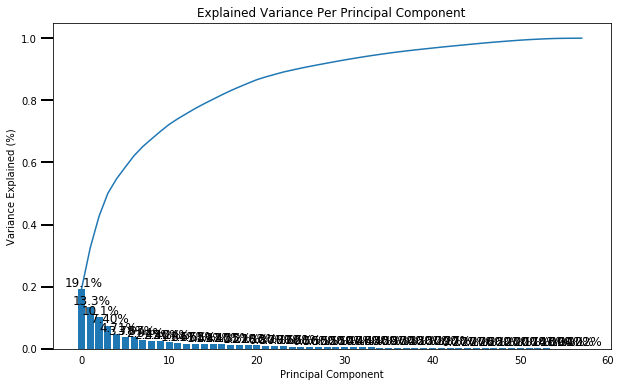

In [102]:
scree_plot(pca)

This plot is a bit crowded as we're including every principal component, so let's plot the first 16 components instead:

In [103]:
pca = PCA(n_components=16)
# fit our cleaned, standardised data to the PCA model, 
# transform our data with said model, returning new array with reduced feature space
azdias_clean_standard_scaled_pc = pca.fit_transform(azdias_clean_standard_scaled)

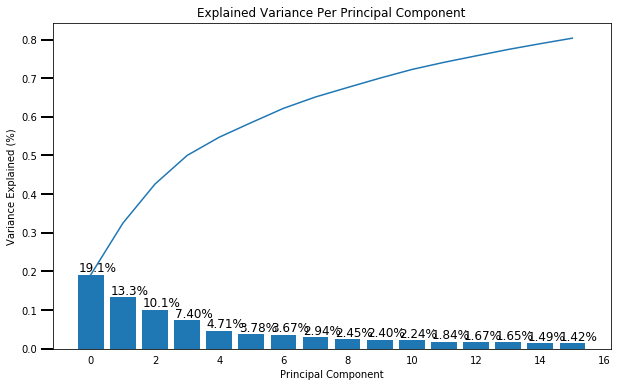

In [104]:
# replot
scree_plot(pca)

From the above we see that approximately 80% of the variance in the dataset is explained by the first 16 principal components.
This is ample for are futute clustering analysis, so we will maintain our second pca model.

## 4.3 Principal component interpretation

Each principal component is a unit vector comprised of weights for each input feature that points in the direction of highest variance (after accounting for the variance explained by earlier principal components). The further a weight is from zero, the more that principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (either positive or negative), then an increase in one will be associated with an increase in the other. In contrast, features with opposite signs can be expected to show a negative correlation, with increases in one resulting in a decrease in the other.

With this knowledge, we can map each weight in a principal component to its corresponding feature name, and, observing the major positively and negatively-weighted features in the principal component, we can start to build a picture of how different values of the principal component relate to the underlying raw features. 
Following from this, by observing the principal component values of a given cluster, we can use these relationships to build a tentative profile of what undelying demographics the cluster represents. 

With this in mind, let's write a function that, for a given principal component, returns the sorted series (with greatest weight first), of feature names to weights

In [105]:
def resolve_pca_weights_to_features(pca_model, comp, features):
    '''Map weights for the first principal component to corresponding feature names'''
    return pd.Series(data=pca_model.components_[comp], index=features).sort_values(ascending=False)

### 4.3.1 Principal component zero

In [106]:
resolve_pca_weights_to_features(pca, 0, azdias_clean.columns)

D19_GESAMT_ANZ_24            0.279248
D19_GESAMT_ANZ_12            0.271913
D19_VERSAND_ANZ_24           0.252601
D19_VERSAND_ANZ_12           0.239855
ONLINE_AFFINITAET            0.225367
D19_BANKEN_ANZ_24            0.163050
D19_VERSI_ANZ_24             0.148702
D19_BANKEN_ANZ_12            0.145923
D19_VERSI_ANZ_12             0.129272
GEBURTSJAHR                  0.128364
D19_TELKO_ANZ_24             0.126365
D19_TELKO_ANZ_12             0.107759
PLZ8_ANTG1                   0.084928
GREEN_AVANTGARDE             0.074940
SEMIO_VERT                   0.069304
FINANZ_MINIMALIST            0.066570
PLZ8_GBZ                     0.059473
SEMIO_KULT                   0.043453
SEMIO_SOZ                    0.041534
SEMIO_TRADV                  0.036002
SEMIO_RAT                    0.008861
SEMIO_PFLICHT                0.003202
SEMIO_MAT                   -0.003810
FINANZ_SPARER               -0.004263
SEMIO_FAM                   -0.006125
FINANZ_ANLEGER              -0.007346
FINANZ_UNAUF

Observe the large, positive weights associated with the ANZ_12 and ANZ_24 suffixed attributes which we saw in the D19 family
in our feature selection analysis. This means that larger values for these raw attributes, will lead to this principal component also taking on larger, postive values.
Let's revisit our data dictionary to remind ourselves what increasing values of these raw attributes signified:

In [107]:
attrib_value_info_lookup("D19_.*ANZ_*[12|24]", ["first", "last"])

Unnamed: 0       \
                        first last   
Attribute                            
D19_BANKEN_ANZ_12         NaN  NaN   
D19_BANKEN_ANZ_24         NaN  NaN   
D19_GESAMT_ANZ_12         NaN  NaN   
D19_GESAMT_ANZ_24         NaN  NaN   
D19_TELKO_ANZ_12          NaN  NaN   
D19_TELKO_ANZ_24          NaN  NaN   
D19_VERSAND_ANZ_12        NaN  NaN   
D19_VERSAND_ANZ_24        NaN  NaN   
D19_VERSI_ANZ_12          NaN  NaN   
D19_VERSI_ANZ_24          NaN  NaN   

                                                          Description  \
                                                                first   
Attribute                                                               
D19_BANKEN_ANZ_12    transaction activity BANKS in the last 12 months   
D19_BANKEN_ANZ_24    transaction activity BANKS in the last 24 months   
D19_GESAMT_ANZ_12   transaction activity TOTAL POOL in the last 12...   
D19_GESAMT_ANZ_24   transaction activity TOTAL POOL in the last 24...   
D19_TELKO_ANZ_12     transaction activity TELCO in the last 12 months   
D19_TELKO_ANZ_24     transaction activity TELCO in the last 24 months   
D19_VERSAND_ANZ_12  transaction activity MAIL-ORDER in the last 12...   
D19_VERSAND_ANZ_24  transaction activity MAIL-ORDER in the last 24...   
D19_VERSI_ANZ_12    transaction activity INSURANCE in the last 12 ...   
D19_VERSI_ANZ_24    transaction activity INSURANCE in the last 24 ...   

                                                                      Value  \
                                                                 last first   
Attribute                                                                     
D19_BANKEN_ANZ_12    transaction activity BANKS in the last 12 months     0   
D19_BANKEN_ANZ_24    transaction activity BANKS in the last 24 months     0   
D19_GESAMT_ANZ_12   transaction activity TOTAL POOL in the last 12...     0   
D19_GESAMT_ANZ_24   transaction activity TOTAL POOL in the last 24...     0   
D19_TELKO_ANZ_12     transaction activity TELCO in the last 12 months     0   
D19_TELKO_ANZ_24     transaction activity TELCO in the last 24 months     0   
D19_VERSAND_ANZ_12  transaction activity MAIL-ORDER in the last 12...     0   
D19_VERSAND_ANZ_24  transaction activity MAIL-ORDER in the last 24...     0   
D19_VERSI_ANZ_12    transaction activity INSURANCE in the last 12 ...     0   
D19_VERSI_ANZ_24    transaction activity INSURANCE in the last 24 ...     0   

                                       Meaning                      
                   last                  first                last  
Attribute                                                           
D19_BANKEN_ANZ_12     6  no transactions known  very high activity  
D19_BANKEN_ANZ_24     6  no transactions known  very high activity  
D19_GESAMT_ANZ_12     6  no transactions known  very high activity  
D19_GESAMT_ANZ_24     6  no transactions known  very high activity  
D19_TELKO_ANZ_12      6  no transactions known  very high activity  
D19_TELKO_ANZ_24      6  no transactions known  very high activity  
D19_VERSAND_ANZ_12    6  no transactions known  very high activity  
D19_VERSAND_ANZ_24    6  no transactions known  very high activity  
D19_VERSI_ANZ_12      6  no transactions known  very high activity  
D19_VERSI_ANZ_24      6  no transactions known  very high activity

In [108]:
attrib_info_clean_lookup("D19_.*ANZ_*[12|24]")

,Description,Information level
Attribute,,
D19_GESAMT_ANZ_12 D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 12...,Household
D19_BANKEN_ ANZ_12 D19_BANKEN_ ANZ_24,transaction activity BANKS in the last 12 and ...,Household
D19_TELKO_ ANZ_12 D19_TELKO_ ANZ_24,transaction activity TELCO in the last 12 and ...,Household
D19_VERSI_ ANZ_12 D19_VERSI_ ANZ_24,transaction activity INSURANCE in the last 12 ...,Household
D19_VERSAND_ ANZ_12 D19_VERSAND_ ANZ_24,transaction activity MAIL-ORDER in the last 12...,Household


We see that this set of attributes gives a measure, for each observation on a household basis,
of the level of transaction activity in the last 24 months across multiple services and utilities,
including insurance, telecommunications and banking. 
Given that a values for these attributes represent increasing levels of activity, we can surmise that population clusters with a high prevailing value for this principal component could represent subgroups with high transaction activity levels across these sectors.

Let's see if the feautures most negatively-weighted by this principal component, The DATUM-suffixed D19 attributes
also encountered in the feature selection analysis, agrees with the above observation:

In [109]:
attrib_value_info_lookup("D19_.*DATUM$", ["first", "last"])

Unnamed: 0       \
                               first last   
Attribute                                   
D19_BANKEN_DATUM                 NaN  NaN   
D19_BANKEN_OFFLINE_DATUM         NaN  NaN   
D19_BANKEN_ONLINE_DATUM          NaN  NaN   
D19_GESAMT_DATUM                 NaN  NaN   
D19_GESAMT_OFFLINE_DATUM         NaN  NaN   
D19_GESAMT_ONLINE_DATUM          NaN  NaN   
D19_TELKO_DATUM                  NaN  NaN   
D19_TELKO_OFFLINE_DATUM          NaN  NaN   
D19_TELKO_ONLINE_DATUM           NaN  NaN   
D19_VERSAND_DATUM                NaN  NaN   
D19_VERSAND_OFFLINE_DATUM        NaN  NaN   
D19_VERSAND_ONLINE_DATUM         NaN  NaN   

                                                                 Description  \
                                                                       first   
Attribute                                                                      
D19_BANKEN_DATUM           actuality of the last transaction for the segm...   
D19_BANKEN_OFFLINE_DATUM   actuality of the last transaction for the segm...   
D19_BANKEN_ONLINE_DATUM    actuality of the last transaction for the segm...   
D19_GESAMT_DATUM           actuality of the last transaction with the com...   
D19_GESAMT_OFFLINE_DATUM   actuality of the last transaction with the com...   
D19_GESAMT_ONLINE_DATUM    actuality of the last transaction with the com...   
D19_TELKO_DATUM            actuality of the last transaction for the segm...   
D19_TELKO_OFFLINE_DATUM    actuality of the last transaction for the segm...   
D19_TELKO_ONLINE_DATUM     actuality of the last transaction for the segm...   
D19_VERSAND_DATUM          actuality of the last transaction for the segm...   
D19_VERSAND_OFFLINE_DATUM  actuality of the last transaction for the segm...   
D19_VERSAND_ONLINE_DATUM   actuality of the last transaction for the segm...   

                                                                              \
                                                                        last   
Attribute                                                                      
D19_BANKEN_DATUM           actuality of the last transaction for the segm...   
D19_BANKEN_OFFLINE_DATUM   actuality of the last transaction for the segm...   
D19_BANKEN_ONLINE_DATUM    actuality of the last transaction for the segm...   
D19_GESAMT_DATUM           actuality of the last transaction with the com...   
D19_GESAMT_OFFLINE_DATUM   actuality of the last transaction with the com...   
D19_GESAMT_ONLINE_DATUM    actuality of the last transaction with the com...   
D19_TELKO_DATUM            actuality of the last transaction for the segm...   
D19_TELKO_OFFLINE_DATUM    actuality of the last transaction for the segm...   
D19_TELKO_ONLINE_DATUM     actuality of the last transaction for the segm...   
D19_VERSAND_DATUM          actuality of the last transaction for the segm...   
D19_VERSAND_OFFLINE_DATUM  actuality of the last transaction for the segm...   
D19_VERSAND_ONLINE_DATUM   actuality of the last transaction for the segm...   

                          Value       \
                          first last   
Attribute                              
D19_BANKEN_DATUM              1   10   
D19_BANKEN_OFFLINE_DATUM      1   10   
D19_BANKEN_ONLINE_DATUM       1   10   
D19_GESAMT_DATUM              1   10   
D19_GESAMT_OFFLINE_DATUM      1   10   
D19_GESAMT_ONLINE_DATUM       1   10   
D19_TELKO_DATUM               1   10   
D19_TELKO_OFFLINE_DATUM       1   10   
D19_TELKO_ONLINE_DATUM        1   10   
D19_VERSAND_DATUM             1   10   
D19_VERSAND_OFFLINE_DATUM     1   10   
D19_VERSAND_ONLINE_DATUM      1   10   

                                                              Meaning  \
                                                                first   
Attribute                                                               
D19_BANKEN_DATUM           highest activity within the last 12 months   
D19_BANKEN_OFFLINE_DATUM   highest activity within the 

In [110]:
attrib_info_clean_lookup("D19_.*DATUM$")

,Description,Information level
Attribute,,
D19_GESAMT_OFFLINE_DATUM,actuality of the last transaction with the com...,Household
D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,Household
D19_GESAMT_DATUM,actuality of the last transaction with the com...,Household
D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segm...,Household
D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segm...,Household
D19_BANKEN_DATUM,actuality of the last transaction for the segm...,Household
D19_TELKO_OFFLINE_DATUM,actuality of the last transaction for the segm...,Household
D19_TELKO_ONLINE_DATUM,actuality of the last transaction for the segm...,Household
D19_TELKO_DATUM,actuality of the last transaction for the segm...,Household


Observe that this the DATUM set of D19 attributes give a measure, per observation on a household basis, 
of the recentness of peak transaction activity across a variety of sectors, with higher values representing increasingly distant (or indeed zero transactions) in the past. Given that the weights assigned to these features in our first principal component are large and negative, we can surmise that larger values of this principal component in a given population cluster
means that onservations with that cluster have had peak trnasactional activity across these various sectors
in the past year, which agrees with our first observation with for this component.

We now understand that the first prinicpal component can be used to interpret the transactional activity of 
a given observation/cluser of observations across the various segments mentioned above. It would be
good to get more colour on this principal component: could large prevailing values in a cluster represent 
those with young families perhaps?

To answer this question, let's take a look at the other major positively-weighted features
associated with principal component 0: ONLINE_AFFINITAET and GEBURTSJAHR:

In [111]:
attrib_value_info_lookup("ONLINE_AFFINITAET|GEBURTSJAHR")

,Unnamed: 0,Attribute,Description,Value,Meaning
711,NaN,GEBURTSJAHR,year of birth,…,numeric value
1997,NaN,ONLINE_AFFINITAET,online affinity,0,none
1998,NaN,ONLINE_AFFINITAET,online affinity,1,low
1999,NaN,ONLINE_AFFINITAET,online affinity,2,middle
2000,NaN,ONLINE_AFFINITAET,online affinity,3,high
2001,NaN,ONLINE_AFFINITAET,online affinity,4,very high
2002,NaN,ONLINE_AFFINITAET,online affinity,5,highest


From this, we see that higher values for principal component 0 in given cluster could be representative
of a younger, more online-orientated subpopulation, which from our analysis above also have high 
transactional activity over a range of utilites and services.

let's take a look at the other major negatively-weighted feature of this component to add more detail to this picture: FINANZ_HAUSBAUER:

In [112]:
attrib_value_info_lookup("FINANZ_HAUSBAUER")

,Unnamed: 0,Attribute,Description,Value,Meaning
667,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,-1,unknown
668,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,1,very high
669,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,2,high
670,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,3,average
671,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,4,low
672,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,5,very low


Decreasing values of FINANZ_HAUSBAUER for a given observation represent an increasing focus on the home and, given that this raw attribute is negatively-weighted in our principal component, and increasing value for it could represent an increasing focus on the home in our underlying population. 
This adds credence to our theory that large values of this principal component in a given cluster could represent young homeowners, possibly mortgage payers, as the core group of said cluster.

The respective weightings of PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG4 , representing the share of N-member family houses in the observations PLZ8 district, may also hint at a positive relationship with new, smaller families, although these relationships are less well-defined than those seen above.

In [113]:
attrib_value_info_lookup("PLZ8_ANTG1|PLZ8_ANTG3|PLZ8_ANTG4")

,Unnamed: 0,Attribute,Description,Value,Meaning
2016,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,-1,unknown
2017,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,0,none
2018,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,1,low share
2019,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,2,average share
2020,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,3,high share
2021,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,4,very high share
2028,NaN,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-1,unknown
2029,NaN,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,0,none
2030,NaN,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,1,low share
2031,NaN,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,2,average share


### 4.3.2 Principal component one

In [114]:
pc_1_feature_weights = resolve_pca_weights_to_features(pca, 1, azdias_clean.columns)
pc_1_feature_weights

FINANZ_SPARER                0.299801
SEMIO_REL                    0.295956
SEMIO_PFLICHT                0.281284
SEMIO_TRADV                  0.252288
FINANZ_UNAUFFAELLIGER        0.243644
FINANZ_ANLEGER               0.225623
SEMIO_RAT                    0.217427
SEMIO_FAM                    0.217395
SEMIO_KULT                   0.216433
SEMIO_MAT                    0.205479
ONLINE_AFFINITAET            0.089490
PLZ8_ANTG3                   0.086904
PLZ8_ANTG4                   0.084945
SEMIO_SOZ                    0.084666
PLZ8_BAUMAX                  0.061678
PLZ8_ANTG2                   0.059658
D19_VERSAND_OFFLINE_DATUM    0.058998
HH_EINKOMMEN_SCORE           0.049566
D19_GESAMT_OFFLINE_DATUM     0.045169
D19_BANKEN_ANZ_24            0.029452
PLZ8_HHZ                     0.027578
D19_BANKEN_ANZ_12            0.025778
D19_GESAMT_DATUM             0.020386
D19_TELKO_ANZ_24             0.019916
D19_VERSAND_DATUM            0.017821
D19_TELKO_ANZ_12             0.015632
FINANZ_HAUSB

Let's take a look at the value codes and descriptions for the most positively-weighted attributes in principal component 1:

In [115]:
attrib_value_info_lookup("|".join(list(pc_1_feature_weights[:10].index)), ["first", "last"])

Unnamed: 0       \
                           first last   
Attribute                               
FINANZ_ANLEGER               NaN  NaN   
FINANZ_SPARER                NaN  NaN   
FINANZ_UNAUFFAELLIGER        NaN  NaN   
SEMIO_FAM                    NaN  NaN   
SEMIO_KULT                   NaN  NaN   
SEMIO_MAT                    NaN  NaN   
SEMIO_PFLICHT                NaN  NaN   
SEMIO_RAT                    NaN  NaN   
SEMIO_REL                    NaN  NaN   
SEMIO_TRADV                  NaN  NaN   

                                                             Description  \
                                                                   first   
Attribute                                                                  
FINANZ_ANLEGER                              financial typology: investor   
FINANZ_SPARER                            financial typology: money saver   
FINANZ_UNAUFFAELLIGER                   financial typology: unremarkable   
SEMIO_FAM              affinity indicating in what way the person is ...   
SEMIO_KULT             affinity indicating in what way the person is ...   
SEMIO_MAT              affinity indicating in what way the person is ...   
SEMIO_PFLICHT          affinity indicating in what way the person is ...   
SEMIO_RAT              affinity indicating in what way the person is ...   
SEMIO_REL              affinity indicating in what way the person is ...   
SEMIO_TRADV            affinity indicating in what way the person is ...   

                                                                          \
                                                                    last   
Attribute                                                                  
FINANZ_ANLEGER                              financial typology: investor   
FINANZ_SPARER                            financial typology: money saver   
FINANZ_UNAUFFAELLIGER                   financial typology: unremarkable   
SEMIO_FAM              affinity indicating in what way the person is ...   
SEMIO_KULT             affinity indicating in what way the person is ...   
SEMIO_MAT              affinity indicating in what way the person is ...   
SEMIO_PFLICHT          affinity indicating in what way the person is ...   
SEMIO_RAT              affinity indicating in what way the person is ...   
SEMIO_REL              affinity indicating in what way the person is ...   
SEMIO_TRADV            affinity indicating in what way the person is ...   

                       Value       Meaning                   
                       first last    first             last  
Attribute                                                    
FINANZ_ANLEGER            -1    5  unknown         very low  
FINANZ_SPARER             -1    5  unknown         very low  
FINANZ_UNAUFFAELLIGER     -1    5  unknown         very low  
SEMIO_FAM              -1, 9    7  unknown  lowest affinity  
SEMIO_KULT             -1, 9    7  unknown  lowest affinity  
SEMIO_MAT              -1, 9    7  unknown  lowest affinity  
SEMIO_PFLICHT          -1, 9    7  unknown  lowest affinity  
SEMIO_RAT              -1, 9    7  unknown  lowest affinity  
SEMIO_REL              -1, 9    7  unknown  lowest affinity  
SEMIO_TRADV            -1, 9    7  unknown  lowest affinity

let's get a better idea of the Descriptions:

In [116]:
set(attrib_value_info_lookup("|".join(list(pc_1_feature_weights[:10].index)))['Description'].values)

{'affinity indicating in what way the person is cultural minded',
 'affinity indicating in what way the person is dutyfull traditional minded',
 'affinity indicating in what way the person is familiar minded',
 'affinity indicating in what way the person is material minded',
 'affinity indicating in what way the person is of a rational mind',
 'affinity indicating in what way the person is religious',
 'affinity indicating in what way the person is traditional minded',
 'financial typology: investor',
 'financial typology: money saver',
 'financial typology: unremarkable'}

We see that increasing values of each of the above attributes represented a *decreasing* affinity for, to name a few:
1. investment-mindedness, 
2. savings-mindedness
3. cultural, tradition and religion-mindedness
4. familiar-mindedness

Therefore, increasing values of principal component one for a given cluster could represent a low-affinity for the above midnsets in the underlying subpopulation. 

Let's a take a look at the major negatively-weighted attributes of principal component 1 to further paint the picture:

In [117]:
attrib_value_info_lookup("|".join(list(pc_1_feature_weights[-5:].index)), ["first", "last"])

Unnamed: 0       \
                          first last   
Attribute                              
ALTERSKATEGORIE_GROB        NaN  NaN   
FINANZ_MINIMALIST           NaN  NaN   
FINANZ_VORSORGER            NaN  NaN   
SEMIO_ERL                   NaN  NaN   
SEMIO_LUST                  NaN  NaN   

                                                            Description  \
                                                                  first   
Attribute                                                                 
ALTERSKATEGORIE_GROB       age classification through prename analysis    
FINANZ_MINIMALIST            financial typology: low financial interest   
FINANZ_VORSORGER                        financial typology: be prepared   
SEMIO_ERL             affinity indicating in what way the person is ...   
SEMIO_LUST            affinity indicating in what way the person is ...   

                                                                         \
                                                                   last   
Attribute                                                                 
ALTERSKATEGORIE_GROB       age classification through prename analysis    
FINANZ_MINIMALIST            financial typology: low financial interest   
FINANZ_VORSORGER                        financial typology: be prepared   
SEMIO_ERL             affinity indicating in what way the person is ...   
SEMIO_LUST            affinity indicating in what way the person is ...   

                      Value       Meaning                         
                      first last    first                   last  
Attribute                                                         
ALTERSKATEGORIE_GROB  -1, 0    9  unknown  uniformly distributed  
FINANZ_MINIMALIST        -1    5  unknown               very low  
FINANZ_VORSORGER         -1    5  unknown               very low  
SEMIO_ERL             -1, 9    7  unknown        lowest affinity  
SEMIO_LUST            -1, 9    7  unknown        lowest affinity

In [118]:
set(attrib_value_info_lookup("|".join(list(pc_1_feature_weights[-5:].index)))['Description'].values)

{'affinity indicating in what way the person is eventful orientated',
 'affinity indicating in what way the person is sensual minded',
 'age classification through prename analysis ',
 'financial typology: be prepared',
 'financial typology: low financial interest'}

The financial topography seems to generally fit our current interpretation of this principal component:  populations with low financial interest will have a larger value for this principal component, although the affinity for "preparedness" and how it agrees or disagrees with the other trends is more difficult to gauge.
Looking at the ALTERSKATEGORIE_GROB value codes:

In [119]:
attrib_value_info_lookup("ALTERSKATEGORIE_GROB")

,Unnamed: 0,Attribute,Description,Value,Meaning
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years
10,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,9,uniformly distributed


we see that an older prevailing age group in a population will lead to a lower value for this principal component due to ALTERSKATEGORIE_GROBs negative weighting.

Overall, We will can interpret this principal component as an indicator for younger,  more fiscally-indifferent groups (possibly college students or school-going dependents) versus more more fiscally-orientated, conservative older groups, with high values for the principal component indicating of the former.

### 4.3.2 Principal component two

In [120]:
pc_2_feature_weights = resolve_pca_weights_to_features(pca, 2, azdias_clean.columns)
pc_2_feature_weights

SEMIO_KAEM                   0.365856
ANREDE_KZ                    0.360837
SEMIO_DOM                    0.333846
SEMIO_KRIT                   0.295232
SEMIO_RAT                    0.193392
SEMIO_ERL                    0.175145
FINANZ_ANLEGER               0.161954
FINANZ_HAUSBAUER             0.096281
FINANZ_SPARER                0.096152
FINANZ_UNAUFFAELLIGER        0.088494
D19_VERSAND_ANZ_24           0.063772
D19_VERSAND_ANZ_12           0.063448
SEMIO_PFLICHT                0.059411
PLZ8_ANTG3                   0.059107
PLZ8_ANTG4                   0.055578
D19_GESAMT_ANZ_12            0.055000
D19_GESAMT_ANZ_24            0.051360
ONLINE_AFFINITAET            0.049203
PLZ8_ANTG2                   0.040640
SEMIO_TRADV                  0.036107
PLZ8_BAUMAX                  0.025581
PLZ8_HHZ                     0.022238
D19_BANKEN_ANZ_24            0.021965
D19_BANKEN_ANZ_12            0.021498
D19_TELKO_ANZ_24             0.020249
HH_EINKOMMEN_SCORE           0.020159
D19_TELKO_AN

Finally for this section, let's build an interpretation of the third principal component:

In [121]:
attrib_value_info_lookup("|".join(list(pc_2_feature_weights[:7].index)), ["first", "last"])

Unnamed: 0       \
                    first last   
Attribute                        
ANREDE_KZ             NaN  NaN   
FINANZ_ANLEGER        NaN  NaN   
SEMIO_DOM             NaN  NaN   
SEMIO_ERL             NaN  NaN   
SEMIO_KAEM            NaN  NaN   
SEMIO_KRIT            NaN  NaN   
SEMIO_RAT             NaN  NaN   

                                                      Description  \
                                                            first   
Attribute                                                           
ANREDE_KZ                                                  gender   
FINANZ_ANLEGER                       financial typology: investor   
SEMIO_DOM       affinity indicating in what way the person is ...   
SEMIO_ERL       affinity indicating in what way the person is ...   
SEMIO_KAEM      affinity indicating in what way the person is ...   
SEMIO_KRIT      affinity indicating in what way the person is ...   
SEMIO_RAT       affinity indicating in what way the person is ...   

                                                                   Value       \
                                                             last  first last   
Attribute                                                                       
ANREDE_KZ                                                  gender  -1, 0    2   
FINANZ_ANLEGER                       financial typology: investor     -1    5   
SEMIO_DOM       affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_ERL       affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_KAEM      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_KRIT      affinity indicating in what way the person is ...  -1, 9    7   
SEMIO_RAT       affinity indicating in what way the person is ...  -1, 9    7   

                Meaning                   
                  first             last  
Attribute                                 
ANREDE_KZ       unknown           female  
FINANZ_ANLEGER  unknown         very low  
SEMIO_DOM       unknown  lowest affinity  
SEMIO_ERL       unknown  lowest affinity  
SEMIO_KAEM      unknown  lowest affinity  
SEMIO_KRIT      unknown  lowest affinity  
SEMIO_RAT       unknown  lowest affinity

In [122]:
set(attrib_value_info_lookup("|".join(list(pc_2_feature_weights[:7].index)))['Description'].values)

{'affinity indicating in what way the person is critical minded',
 'affinity indicating in what way the person is dominant minded',
 'affinity indicating in what way the person is eventful orientated',
 'affinity indicating in what way the person is of a fightfull attitude',
 'affinity indicating in what way the person is of a rational mind',
 'financial typology: investor',
 'gender'}

The above suggests that higher values for this principal component are indicative of mostly female populations, particulary those that are not investment minded. The semio attributes here do not seem particularly useful from a marketing perspective: stating that higher values for this component would be associated with less dominant/fightful/critically-minded groups

Let's take a look the a the major negatively-weighted attributes of this component:

In [123]:
attrib_value_info_lookup("|".join(list(pc_2_feature_weights[-5:].index)), ["first", "last"])

Unnamed: 0       \
                       first last   
Attribute                           
FINANZ_MINIMALIST        NaN  NaN   
SEMIO_FAM                NaN  NaN   
SEMIO_KULT               NaN  NaN   
SEMIO_SOZ                NaN  NaN   
SEMIO_VERT               NaN  NaN   

                                                         Description  \
                                                               first   
Attribute                                                              
FINANZ_MINIMALIST         financial typology: low financial interest   
SEMIO_FAM          affinity indicating in what way the person is ...   
SEMIO_KULT         affinity indicating in what way the person is ...   
SEMIO_SOZ          affinity indicating in what way the person is ...   
SEMIO_VERT         affinity indicating in what way the person is ...   

                                                                      Value  \
                                                                last  first   
Attribute                                                                     
FINANZ_MINIMALIST         financial typology: low financial interest     -1   
SEMIO_FAM          affinity indicating in what way the person is ...  -1, 9   
SEMIO_KULT         affinity indicating in what way the person is ...  -1, 9   
SEMIO_SOZ          affinity indicating in what way the person is ...  -1, 9   
SEMIO_VERT         affinity indicating in what way the person is ...  -1, 9   

                        Meaning                   
                  last    first             last  
Attribute                                         
FINANZ_MINIMALIST    5  unknown         very low  
SEMIO_FAM            7  unknown  lowest affinity  
SEMIO_KULT           7  unknown  lowest affinity  
SEMIO_SOZ            7  unknown  lowest affinity  
SEMIO_VERT           7  unknown  lowest affinity

In [124]:
set(attrib_value_info_lookup("|".join(list(pc_2_feature_weights[-5:].index)))['Description'].values)

{'affinity indicating in what way the person is cultural minded',
 'affinity indicating in what way the person is dreamily',
 'affinity indicating in what way the person is familiar minded',
 'affinity indicating in what way the person is social minded',
 'financial typology: low financial interest'}

Again it is quite difficult to discern anything of marketing value from these features. The negative weighting of FINANZ_MINIMALIST	does agree with what we saw for the positively weighted attributes, leading us to interpret this component as an indicator for finanically-savviness, with higher values indicating lower financial interest.

Apart from that, the key takeway is that this component may be a usefull indicator for the prevailing gender in clusters, with higher values denoting a predominantly female group.

# 5. Customer segmentation report

## 5.1 Clustering the general population

In [125]:
from sklearn.cluster import KMeans

Having assessed, cleaned and scaled our general population dataset, and just now have decomposing it into a reduced feature space using PCA, we are now ready to use unsupervised learning techniques to reveal it's underlying demographic clusters which have been hinted at in the previous sections. In particular, we will use the sklearns KMeans algorithm to perform this clustering step.

It's  important to take stock the "unsupervised" aspect of this section. Note that we do not have any predefined label for every single observation in our dataset that defines what demographic cluster it belongs to, such as college student, urban young professional and so on. Instead, the goal here is to assign an optimal number of clusters to our KMeans algorithm so that it can provide a realistic topology of the underlying demographic groups in our general population.

How do we find this optimal number of clusters? Well, let's assume we use KMeans to cluster the demographics data into n clusters, and use as its performance metric the average within-cluster distance from each observation to its assigned cluster centroid. Additional clusters will always resulting in a lowering of this average distance, so what we're looking for is some value n such that adding clusters past this point returns a diminishing pay-off (ie: the rate of decrease of average distance to assigned centroid for each observations flattens out).

With this in mind, Let's compute and plot, for a set of KMeans models with increasing values of K (cluster count), the average difference from each observation to its assigned cluster center:

In [126]:
# note: this function is taken from the unsupervised learning course content
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    print("Running KMeans with number of clusters: {}".format(center))
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

Running KMeans with number of clusters: 1
Running KMeans with number of clusters: 2
Running KMeans with number of clusters: 3
Running KMeans with number of clusters: 4
Running KMeans with number of clusters: 5
Running KMeans with number of clusters: 6
Running KMeans with number of clusters: 7
Running KMeans with number of clusters: 8
Running KMeans with number of clusters: 9
Running KMeans with number of clusters: 10
Running KMeans with number of clusters: 11
Running KMeans with number of clusters: 12
Running KMeans with number of clusters: 13
Running KMeans with number of clusters: 14
Running KMeans with number of clusters: 15


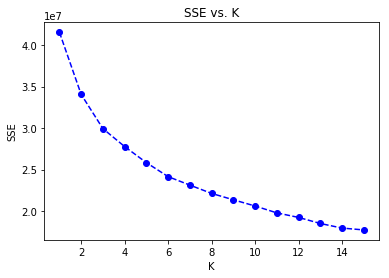

In [127]:
scores = []
# KMeans can take a while to run, so let's limit ourselves to number of clusters 1 through to 15
centers = list(range(1,16))

for center in centers:
    scores.append(get_kmeans_score(azdias_clean_standard_scaled_pc, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

Remember that in the above plot we are trying to detect a "flattening out" of the rate of decrease of the average within-cluster distance of each observation to its assigned centroid with increasing values of K.
This "elbow" appears to start just after 4 clusters, therefore we will it as our optimumn cluster.
With this in mind, let's create a final KMeans objects with 4 centers and again fit our general dataset to it:

In [128]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# instantiate kmeans with 4 clusters
kmeans = KMeans(n_clusters=4)

# Then fit the model to the data using the fit method
kmeans_model = kmeans.fit(azdias_clean_standard_scaled_pc)

# Finally predict the labels on the same data to show the category that each observation belongs to
labels_azdias = kmeans_model.predict(azdias_clean_standard_scaled_pc)

## 5.2 Mapping existing customers to demographic clusters

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

Now that we have obtained the cluster centers for the general population, it's time to map our customer dataset to these clusters. That is, we will apply the same preprocessing, scaling and feature decomposition steps on the customer data as we applied to the general data, taking care to re-use the same standard scaler and pca objects.

An implicit assumption in this step is that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.

Let' write a function to gather the necessary steps:

In [129]:
def clean_customer_dataframe(df, standard_scaler_model=scaler, pca_model=pca, cluster_model=kmeans_model):
    '''
    INPUT:
    df - (pandas dataframe) a dataframe containing customer data
    standard_scaler_model - (StandardScaler model) - StandardScaler object fitted with general demographics data
    pca_model - (PCA model) - PCA object fitted with general demographics data
    cluster_model - (KMeans model) - KMeans object fitted with general demographics data
    
    OUTPUT:
    customer_clean_standard_scaled_pc - (array) transformed customer array based on input criteria
    labels_customer - (int array) cluster predictions for each customer observation based on input KMeans model
    '''
    df_clean = clean_demographic_dataframe(df)
    # transform with our standard scaler model
    customer_clean_standard_scaled = standard_scaler_model.transform(df_clean)
    # transform to a reduced feature space using our PCA model
    customer_clean_standard_scaled_pc = pca_model.transform(customer_clean_standard_scaled)
    print("df_clean_standard_scaled_pc shape: {}".format(customer_clean_standard_scaled_pc.shape))
    # finally, obtain cluster predictions using our KMeans model
    labels_customer = cluster_model.predict(customer_clean_standard_scaled_pc)
    return customer_clean_standard_scaled_pc, labels_customer

In [130]:
# run function on customers dataset
customer_clean_standard_scaled_pc, labels_customer = clean_customer_dataframe(customers)

input dataframe shape: (191652, 369)
replacing missing value codes: [-1, 0, 9] with np.nan for attribute: ALTERSKATEGORIE_GROB
replacing missing value codes: [-1, 0] with np.nan for attribute: ANREDE_KZ
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_ANLEGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_HAUSBAUER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_MINIMALIST
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_SPARER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_UNAUFFAELLIGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_VORSORGER
replacing missing value codes: [-1.0, 0.0] with np.nan for attribute: HH_EINKOMMEN_SCORE
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG1
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG2
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG3

A point of interest here is that the attributes in need of imputing in the customers dataset are the same as those in the general dataset.

## 5.3 Comparision of the customer and demographics data

We have now clustered the underlying demographics of the general population, and have mapped the companys customer base onto that same cluster space. With these tools we are now in a position to identify the core demographics of the companies customer base.

How can we achieve this? Well, by plotting the distribution of the general population across our four clusters and repeating this for our customer base, we can visualise the clusters that are either underrepresented or overpresented in our customer base relative to the general population. 
Furthermore, by plotting the prevailing values of our major principal components in these clusters, we can use the interpretations built in our earlier PCA section to delineate the core and non-core demographics of the companys customer base.

With this in mind, let's plot the distribution of the general and customer populations across the four clusters:

In [131]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def plot_cluster_prop_comparision(labels_general, labels_customer):
    fig, ax =plt.subplots(1,2)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Cluster proportions - general versus customer populations', fontsize=16)
    sns.countplot(x='general', data=pd.DataFrame(data=labels_general, columns=['general']), ax=ax[0])
    sns.countplot(x='customer', data=pd.DataFrame(data=labels_customer, columns=['customer']), ax=ax[1])
    fig.show()
    return None

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


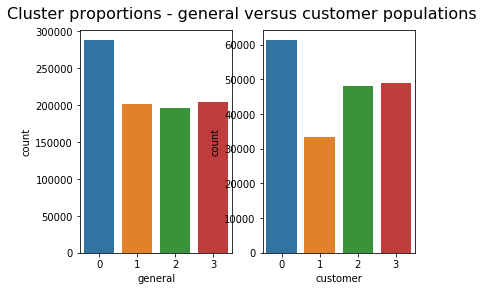

In [132]:
plot_cluster_prop_comparision(labels_azdias, labels_customer)

Observing the above plots, we see that clusters 2 and 3 are overrepresented in the customer population relative to the general population, whereas cluster 1 is underrepresented. It follows that future marketing campaigns should target the observations underlying clusters 2 and 3, whilst avoid those occupying 1.
As stated above, to build a demographic profile of the overrepresented clusters (and therefore identify a core customer base),
We need to plot the prevailing values of the principal components in their underlying observations:

In [133]:
def plot_pc_average_within_cluster(features, labels, cluster):
    '''
    INPUT:
    features - (m x n array) n principal components for m observations
    labels - (m array) - corresponding cluster labels
    cluster - (int) - cluster of interest
    
    OUTPUT:
    None: prints a bar plot of the average principal component values across obervations assigned to cluster
    '''
    labelled_features = np.concatenate((features, np.reshape(labels, (features.shape[0], 1))), axis=1)
    labelled_features_within_cluster = labelled_features[np.where(cluster == labelled_features[:,-1])]
    feature_len = features.shape[1]
    labelled_features_within_cluster_pc_avg = np.average(labelled_features_within_cluster, axis=0)[0:feature_len]
    plt.bar(list(range(len(labelled_features_within_cluster_pc_avg))), labelled_features_within_cluster_pc_avg)
    return None

Note that at this point we could use either the labelled general population data or the labelled customer population to characterize each clusters underlying demographics, we choose to use the general population as the larger sample size should provide a more holistic view of each cluster

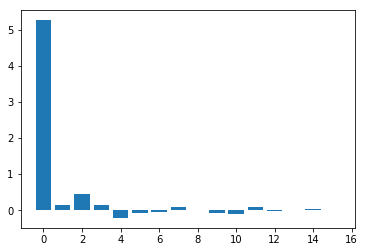

In [154]:
# plot the average value for each principal component across the general population observations assigned to cluster 2
plot_pc_average_within_cluster(azdias_clean_standard_scaled_pc, labels_azdias, 2)

Observe that average value of principal component zero for the general observations in cluster 2 is massively positive relative to the average of every other principal component in this cluster, which all group around zero.

Referring back to our PCA interpretation analysis, we know that large positive values of principal component zero possibly suggested an underlying pool of young homeowners, possibly still paying the mortgage, with a young, small-sized family in tow.

Given that cluster one is *over-represented* in our customer data relative to our general population, this suggests that this demographic provides a core user base to the company.

Next, let's take a look at the cluster *under-represented* in the customer data relative to the general population, cluster 1:

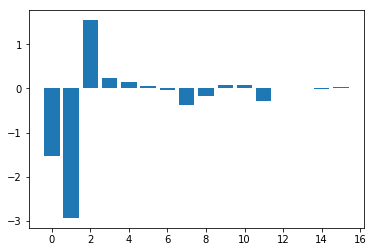

In [155]:
# plot the average value for each principal component across the general population observations assigned to cluster 1
plot_pc_average_within_cluster(azdias_clean_standard_scaled_pc, labels_azdias, 1)

For this cluster, observe that the average of principal component one takes on a large, negative value relative to most of the other components. This is in contrast to the previous cluster which suggests we are dealing with quite a distinct demographic relative to the first. 

Principal component one is of the main interest here, which has the largest absolute average value but overall is negative in nature. Againing referring back to our PCA interpretation analysis, we noted that large, negative values of principal component one suggested a fiscally-conservative, older demographic. 

Given that cluster one is *under-represented* in our customer data relative to our general population, this suggests that this demographic is outside the core user base to the company.

Also observe the relatively large, positive average value of principal component two in this cluster, which we interpreted as indicative of groups predominantly made up of females with low interest in financial matters. Again, the suggestion here is that this demographic is outside the core user base to the company.

# 6. Supervised learning model

Now that we've found which groups of the population are more likely to be customers of the company, we can build a prediction model. Each of the records in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, we can verify our model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, we'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [136]:
# load in the training data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [137]:
# randomly pick 20% of records as validation set
mailout_test = mailout_train.sample(frac=0.2)

In [138]:
# keep the rest for training
mailout_train.drop(mailout_test.index, inplace=True)

In [139]:
# verify 
mailout_test.shape, mailout_train.shape

((8592, 367), (34370, 367))

In [140]:
X_train = clean_customer_dataframe(mailout_train)[0]
y_train = mailout_train['RESPONSE'].values
X_test = clean_customer_dataframe(mailout_test)[0]
y_test = mailout_test['RESPONSE'].values

input dataframe shape: (34370, 367)
replacing missing value codes: [-1, 0, 9] with np.nan for attribute: ALTERSKATEGORIE_GROB
replacing missing value codes: [-1, 0] with np.nan for attribute: ANREDE_KZ
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_ANLEGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_HAUSBAUER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_MINIMALIST
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_SPARER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_UNAUFFAELLIGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_VORSORGER
replacing missing value codes: [-1.0, 0.0] with np.nan for attribute: HH_EINKOMMEN_SCORE
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG1
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG2
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG3


In [141]:
# initial model evaluation pipeline

In [142]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [143]:
# Initialize the three models
clf_A = RandomForestClassifier()
clf_B = AdaBoostClassifier()
clf_C = SVC()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(10*(len(y_train)/100))
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 343 samples.
RandomForestClassifier trained on 3437 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 34370 samples.
AdaBoostClassifier trained on 343 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoostClassifier trained on 3437 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoostClassifier trained on 34370 samples.
SVC trained on 343 samples.
SVC trained on 3437 samples.
SVC trained on 34370 samples.


In [144]:
results

{'RandomForestClassifier': {0: {'train_time': 0.1762697696685791,
   'pred_time': 0.0100555419921875,
   'acc_train': 0.98666666666666669,
   'acc_test': 0.98847765363128492,
   'f_train': 0.78947368421052622,
   'f_test': 0.0},
  1: {'train_time': 0.09026145935058594,
   'pred_time': 0.009778022766113281,
   'acc_train': 0.9966666666666667,
   'acc_test': 0.98847765363128492,
   'f_train': 0.96774193548387089,
   'f_test': 0.0},
  2: {'train_time': 1.8112154006958008,
   'pred_time': 0.015758514404296875,
   'acc_train': 0.9966666666666667,
   'acc_test': 0.98847765363128492,
   'f_train': 0.96774193548387089,
   'f_test': 0.0}},
 'AdaBoostClassifier': {0: {'train_time': 0.10934257507324219,
   'pred_time': 0.06529426574707031,
   'acc_train': 1.0,
   'acc_test': 0.98172718808193671,
   'f_train': 1.0,
   'f_test': 0.014749262536873156},
  1: {'train_time': 0.41838502883911133,
   'pred_time': 0.059159278869628906,
   'acc_train': 0.97666666666666668,
   'acc_test': 0.9866154562383612

In [145]:
# model tuning

In [146]:
# Initialize the classifier
clf =RandomForestClassifier()

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = { 'n_estimators' : [50, 100, 150, 200] }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

Unoptimized model
------
Accuracy score on testing data: 0.9885
F-score on testing data: 0.0000

Optimized Model
------
Final accuracy score on the testing data: 0.9885
Final F-score on the testing data: 0.0000


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# 7. Kaggle Competition

In [147]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [148]:
X_test = clean_customer_dataframe(mailout_test)[0]

input dataframe shape: (42833, 366)
replacing missing value codes: [-1, 0, 9] with np.nan for attribute: ALTERSKATEGORIE_GROB
replacing missing value codes: [-1, 0] with np.nan for attribute: ANREDE_KZ
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_ANLEGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_HAUSBAUER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_MINIMALIST
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_SPARER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_UNAUFFAELLIGER
replacing missing value codes: [-1] with np.nan for attribute: FINANZ_VORSORGER
replacing missing value codes: [-1.0, 0.0] with np.nan for attribute: HH_EINKOMMEN_SCORE
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG1
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG2
replacing missing value codes: [-1.0] with np.nan for attribute: PLZ8_ANTG3


In [149]:
mailout_test_predictions = best_clf.predict_proba(X_test)[:, 1]

In [150]:
kaggle_submission = mailout_test[['LNR']]

In [151]:
kaggle_submission['RESPONSE'] = mailout_test_predictions

In [152]:
kaggle_submission.head()

,LNR,RESPONSE
0,1754,0.02
1,1770,0.02
2,1465,0.04
3,1470,0.00
4,1478,0.04


In [153]:
kaggle_submission.to_csv("kaggle_submission.csv")